# Import libraries

In [1]:
from collections import Counter
from pathlib import Path

# libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# libraries for text and data processing
import nltk
import numpy as np
import pandas as pd
from PIL import Image
import ast
import re

# libraries for machine learning
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


# statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats
from scipy.stats import spearmanr, mannwhitneyu, gmean
from scipy.stats import ttest_ind
import powerlaw

# remove warnings
import warnings
warnings.filterwarnings("ignore")

# enable autoreload to automatically reload modified modules during development
%load_ext autoreload
%autoreload 2

# download necessary nltk dependencies quietly
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

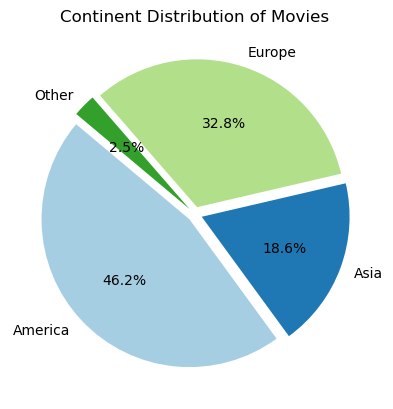
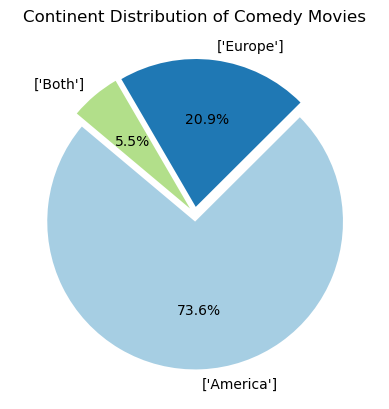

# <h1 style="text-align:center; color: #FF6347;">AXE 1 : Commercial and Critical Success: A Comparative Study of Comedy Films in Europe and America 🎬🌍🇪🇺🇺🇸</h1>

This project examines the relationship between commercial success (box office) and critical acclaim (awards, ratings) specifically for comedy films in Europe versus those in America. By using OMDB data on revenues, ratings, and awards, we aim to analyze how these factors interact and differ by geographic context. The goal is to uncover the dynamics of success in the comedy genre within the global film industry, identifying what contributes to making a comedy film both profitable and critically acclaimed.

## Load the Merged DataFrame for Rating Analysis

The file **`merged_movie_metadata_update.csv`** is the same as the preprocessed data **`merged_movie_metadata.csv`** in **`preprocessing.ipynb`**. We just added a classification column specifically for **comedy genres**.

A new genre classification now includes comedy subgenres, such as tragicomedy and satire. This section creates functions to generate combined subgenres, for example, "Comedy_Romance" for "romance" and "romantic."

In [2]:
from src.utils.data_utils import determine_types, simplify_continent

# load the CSV file containing movie metadata
merged_movie_metadata = pd.read_csv('data/merged_movie_metadata_update.csv')

# convert elements in the 'comedy_genres' column to a list of strings
# if the entry is already a string, evaluate it; otherwise, leave it as-is
merged_movie_metadata['comedy_genres'] = merged_movie_metadata['comedy_genres'].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)

In [3]:
# load the dataset and drop duplicate rows
dataset = pd.read_csv('data/merged_movie_metadata.csv').drop_duplicates().reset_index(drop=True)

# create a copy of the dataset for genre cleaning
dataset_Genre_Cleaned = dataset.copy(deep=False)

# classify genres using determine_types
dataset_Genre_Cleaned['Types'] = dataset_Genre_Cleaned['Genres'].apply(determine_types)

# count and display the occurrences of each type in the 'Types' column
dataset_Genre_Cleaned['Types'].explode().value_counts()

# simplify continent names
dataset_Genre_Cleaned['Continents'] = dataset_Genre_Cleaned['Continents'].apply(
    lambda x: simplify_continent(ast.literal_eval(x))
)

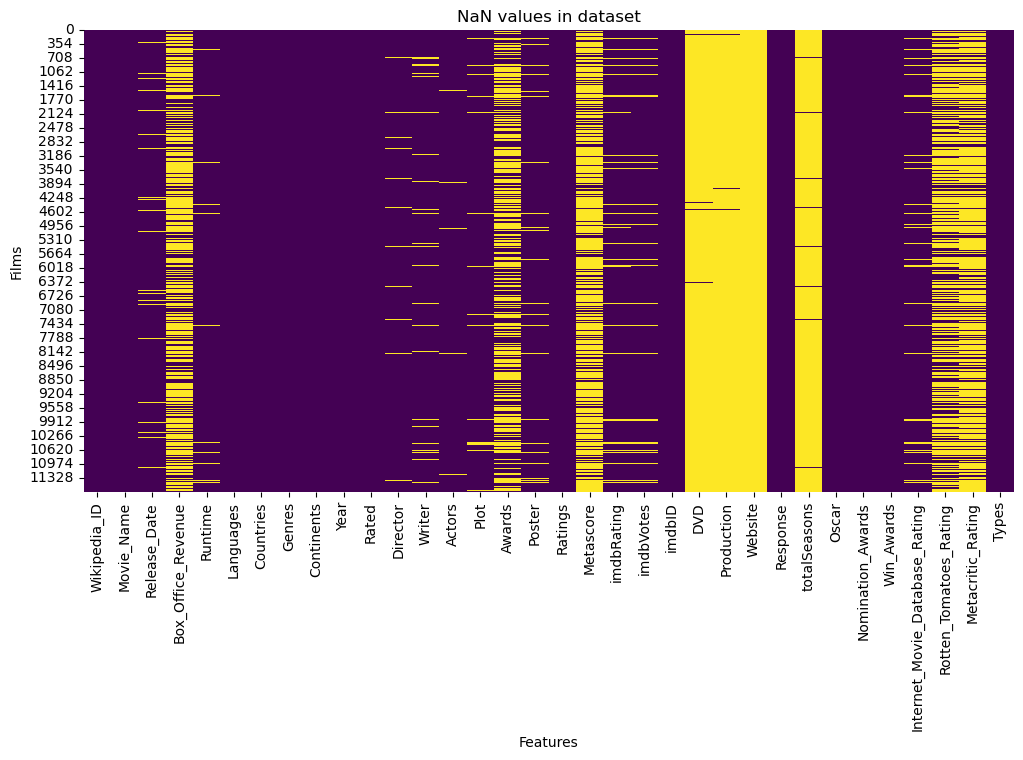

In [4]:
# create a mask for NaN values in the dataset
nan_mask_dropped = dataset_Genre_Cleaned.isna()

# plot the NaN values as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(nan_mask_dropped, cbar=False, cmap='viridis')
plt.title('NaN values in dataset')
plt.xlabel('Features')
plt.ylabel('Films')
plt.show()

## Popularity vs. Quality: A Comparative Study of Box Office and Ratings


This code analyzes box office revenue for various comedy subgenres across different continents (America, Europe, and combined). It begins by cleaning and preparing the data, then visualizes revenue distributions by continent through histograms and comparative plots. Descriptive statistics are calculated for each continent. The code tests several statistical distributions to fit the data and identifies the best one. It also examines the most profitable comedy subgenres by continent. Finally, it evaluates correlations between box office revenue and critic ratings (IMDb, Rotten Tomatoes, Metacritic) for each continent using Spearman correlation.

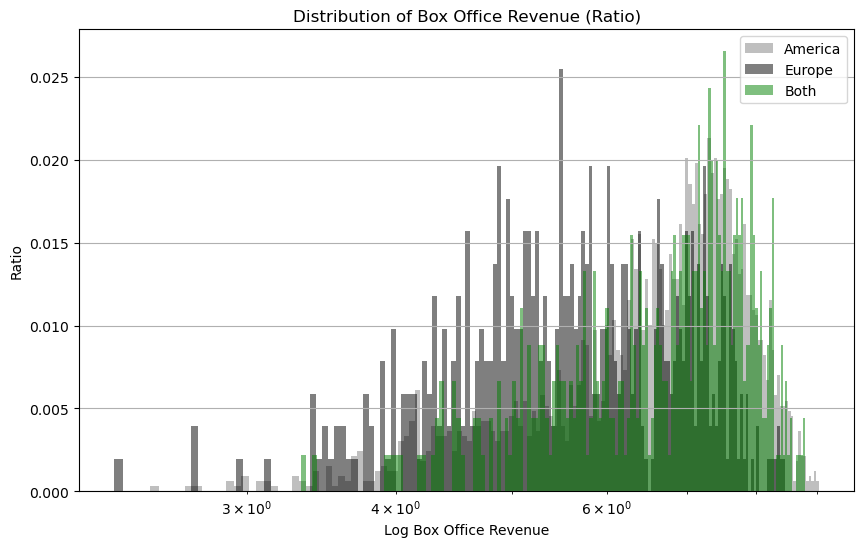

In [5]:
# ensure 'Box_Office_Revenue' contains valid float values
merged_movie_metadata['Box_Office_Revenue'] = pd.to_numeric(
    merged_movie_metadata['Box_Office_Revenue'], errors='coerce'
)

# drop rows with NaN values in the 'Box_Office_Revenue' column
revenue_data = merged_movie_metadata.dropna(subset=['Box_Office_Revenue'])

# apply logarithmic transformation to 'Box_Office_Revenue' to reduce skewness
revenue_data['Log_Box_Office_Revenue'] = np.log10(revenue_data['Box_Office_Revenue'] + 1)  # avoid log(0)

# define the continents to plot and their respective colors
continents = ['America', 'Europe', 'Both']
colors = ['grey', 'black', 'green']

# create a histogram plot
plt.figure(figsize=(10, 6))
for continent, color in zip(continents, colors):
    # filter data for the specific continent
    continent_data = revenue_data[revenue_data['Continents'].apply(lambda x: continent in x)]
    total_count = len(continent_data)
    
    # plot histogram with weights to normalize the ratio
    plt.hist(
        continent_data['Log_Box_Office_Revenue'], bins=150, color=color, alpha=0.5,
        label=continent, weights=[1 / total_count] * total_count
    )

# add title, labels, and legend
plt.title('Distribution of Box Office Revenue (Ratio)')
plt.xlabel('Log Box Office Revenue')
plt.ylabel('Ratio')

# set x-axis to logarithmic scale for better visualization
plt.xscale('log')

# activate grid and add legend
plt.grid(True)
plt.legend()

# display the plot
plt.show()

In [6]:
# calculate basic statistics for 'Box_Office_Revenue' for each continent
continent_stats = {}
for continent in continents:
    # filter data for the specific continent
    continent_data = revenue_data[revenue_data['Continents'].apply(lambda x: continent in x)]
    
    # calculate statistics
    continent_stats[continent] = {
        'Mean': continent_data['Box_Office_Revenue'].mean(),
        'Median': continent_data['Box_Office_Revenue'].median(),
        'Standard Deviation': continent_data['Box_Office_Revenue'].std(),
        'Q1': continent_data['Box_Office_Revenue'].quantile(0.25),
        'Q3': continent_data['Box_Office_Revenue'].quantile(0.75)
    }

# convert the dictionary to a DataFrame for easier visualization
continent_stats_df = pd.DataFrame(continent_stats).T

# display the DataFrame with statistics
display(continent_stats_df)

Mean      Median  Standard Deviation         Q1           Q3
America  4.215332e+07   9600000.0        9.358275e+07  1228108.0  37591674.00
Europe   1.014050e+07    596858.0        2.982646e+07    87859.5   6740334.50
Both     4.135660e+07  11245111.0        7.896562e+07   969703.0  44369854.25

American films generate significantly higher average box office revenues (~42.2M) compared to European films (~10.1M). In Europe, the much lower median (~596K vs. ~9.6M in the U.S.) indicates a high proportion of low-revenue films, reflecting an asymmetric distribution. The high standard deviation for American films reveals substantial variability, driven by a few high-budget blockbusters, whereas in Europe, the lower standard deviation  shows a revenue distribution more concentrated around modest values.

In [7]:
# load box office revenue data into a list (drop NaN values)
box_office_revenues = merged_movie_metadata['Box_Office_Revenue'].dropna().values

# list of distributions to test
distributions = ['lognorm', 'expon', 'gamma', 'norm', 'pareto']

# store results for goodness-of-fit evaluation
results = []

# fit each distribution and evaluate goodness of fit
for distribution in distributions:
    dist = getattr(stats, distribution)
    params = dist.fit(box_office_revenues)
    
    # calculate goodness of fit using Kolmogorov-Smirnov test
    ks_stat, ks_p_value = stats.kstest(box_office_revenues, distribution, args=params)
    log_likelihood = np.sum(dist.logpdf(box_office_revenues, *params))
    
    # append results
    results.append({
        'Distribution': distribution,
        'KS Statistic': ks_stat,
        'KS p-value': ks_p_value,
        'Log-Likelihood': log_likelihood,
        'Params': params
    })

# convert results to a DataFrame for cleaner display
results_df = pd.DataFrame(results).sort_values(by='KS Statistic')

# display the results DataFrame
print("Goodness of Fit Results for Distributions:\n")
print(results_df[['Distribution', 'KS Statistic', 'KS p-value', 'Log-Likelihood']].to_string(index=False))

# identify the best-fitting distribution
best_fit = results_df.iloc[0]
print(
    f"\nThe best-fitting distribution is {best_fit['Distribution']} "
    f"with a KS Statistic of {best_fit['KS Statistic']:.4f} "
    f"and a Log-Likelihood of {best_fit['Log-Likelihood']:.4f}."
)

Goodness of Fit Results for Distributions:

Distribution  KS Statistic   KS p-value  Log-Likelihood
     lognorm      0.084912 4.340931e-27   -7.519162e+04
      pareto      0.120980 1.260266e-54   -7.575926e+04
       expon      0.329296 0.000000e+00   -7.839527e+04
        norm      0.331030 0.000000e+00   -8.368958e+04
       gamma      1.000000 0.000000e+00            -inf

The best-fitting distribution is lognorm with a KS Statistic of 0.0849 and a Log-Likelihood of -75191.6241.


It is entirely expected for the log-normal distribution to be the best fit for box office revenues, as it effectively represents distributions where the majority of values are low but with some high extreme values.

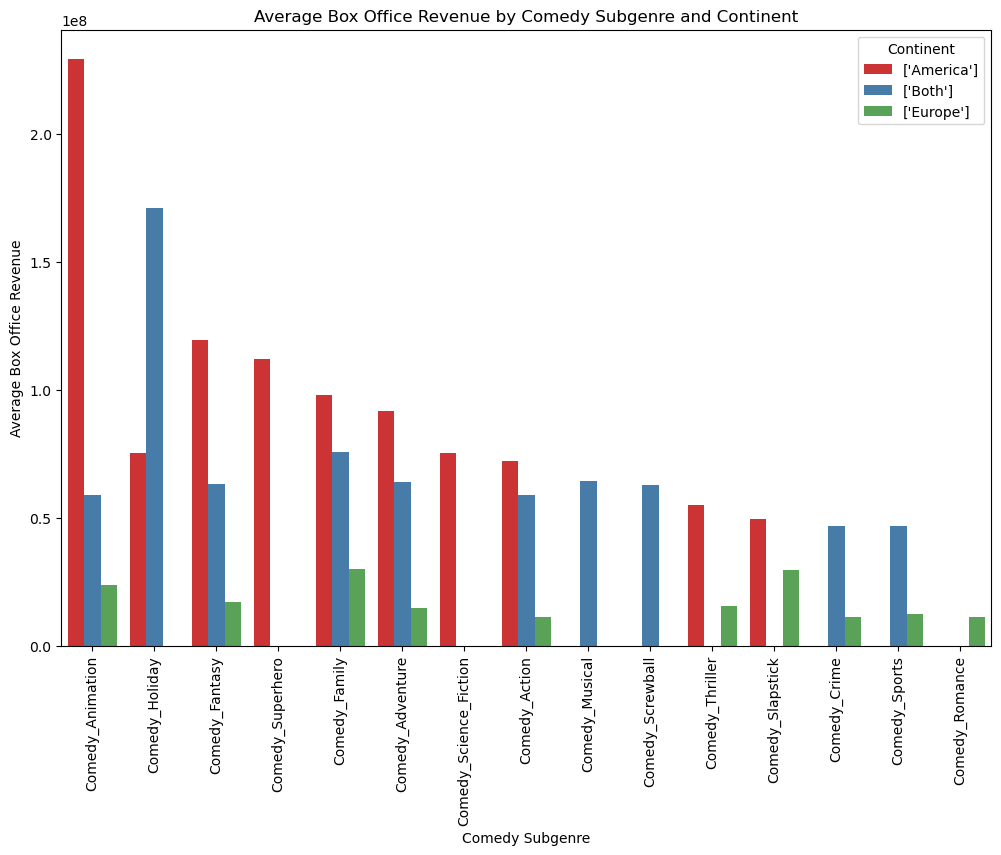

In [8]:
# remove rows with 0 or NaN in the 'Box_Office_Revenue' column
filtered_data = merged_movie_metadata[
    merged_movie_metadata['Box_Office_Revenue'].notna() & (merged_movie_metadata['Box_Office_Revenue'] != 0)
]

# calculate average box office revenue by comedy subgenre and continent
average_revenue_by_genre_continent = (
    filtered_data.explode('comedy_genres')
    .groupby(['comedy_genres', 'Continents'])['Box_Office_Revenue']
    .mean()
    .reset_index()
)

# identify the top 10 most popular comedy subgenres by continent
top_genres_by_continent = (
    average_revenue_by_genre_continent
    .sort_values(by='Box_Office_Revenue', ascending=False)
    .groupby('Continents')
    .head(10)
)

# create comparative barplot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_genres_by_continent,
    x='comedy_genres',
    y='Box_Office_Revenue',
    hue='Continents',
    palette='Set1'
)

# add a title and labels
plt.title('Average Box Office Revenue by Comedy Subgenre and Continent')
plt.xlabel('Comedy Subgenre')
plt.ylabel('Average Box Office Revenue')
plt.xticks(rotation=90)
plt.legend(title='Continent')

# display
plt.show()

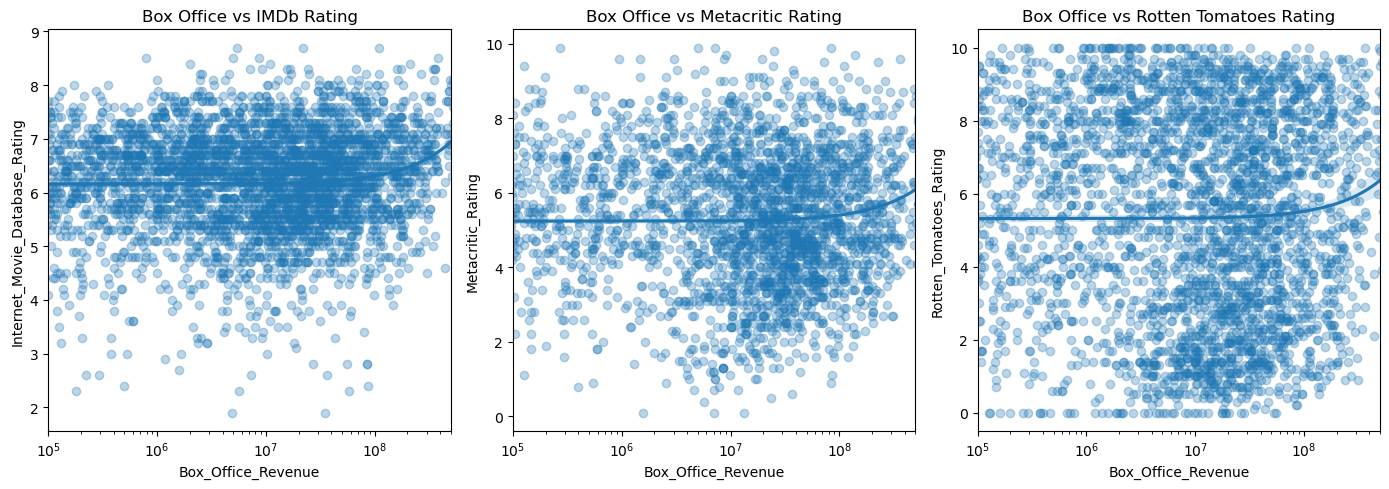

In [9]:
# filter data to include rows with non-null values for 'Box_Office_Revenue' and at least one rating
filtered_data = merged_movie_metadata.dropna(
    subset=['Box_Office_Revenue', 'Internet_Movie_Database_Rating', 'Rotten_Tomatoes_Rating', 'Metacritic_Rating'], 
    how='all'
)

# create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# plot 1: box office vs IMDb rating
sns.regplot(
    data=filtered_data, x='Box_Office_Revenue', y='Internet_Movie_Database_Rating', ax=axes[0],
    scatter_kws={'alpha': 0.3}
)
axes[0].set_xscale("log")
axes[0].set_xlim(1e5, 0.5e9)
axes[0].set_title('Box Office vs IMDb Rating')

# plot 2: box office vs Metacritic rating
sns.regplot(
    data=filtered_data, x='Box_Office_Revenue', y='Metacritic_Rating', ax=axes[1],
    scatter_kws={'alpha': 0.3}
)
axes[1].set_xscale("log")
axes[1].set_xlim(1e5, 0.5e9)
axes[1].set_title('Box Office vs Metacritic Rating')

# plot 3: box office vs Rotten Tomatoes rating
sns.regplot(
    data=filtered_data, x='Box_Office_Revenue', y='Rotten_Tomatoes_Rating', ax=axes[2],
    scatter_kws={'alpha': 0.3}
)
axes[2].set_xscale("log")
axes[2].set_xlim(1e5, 0.5e9)
axes[2].set_title('Box Office vs Rotten Tomatoes Rating')

# adjust layout for better spacing and display
plt.tight_layout()
plt.show()

For a relationship between box office and score, Spearman correlation is more appropriate because it is less affected by outliers and better suited to non-linear relationships and asymmetric distributions.

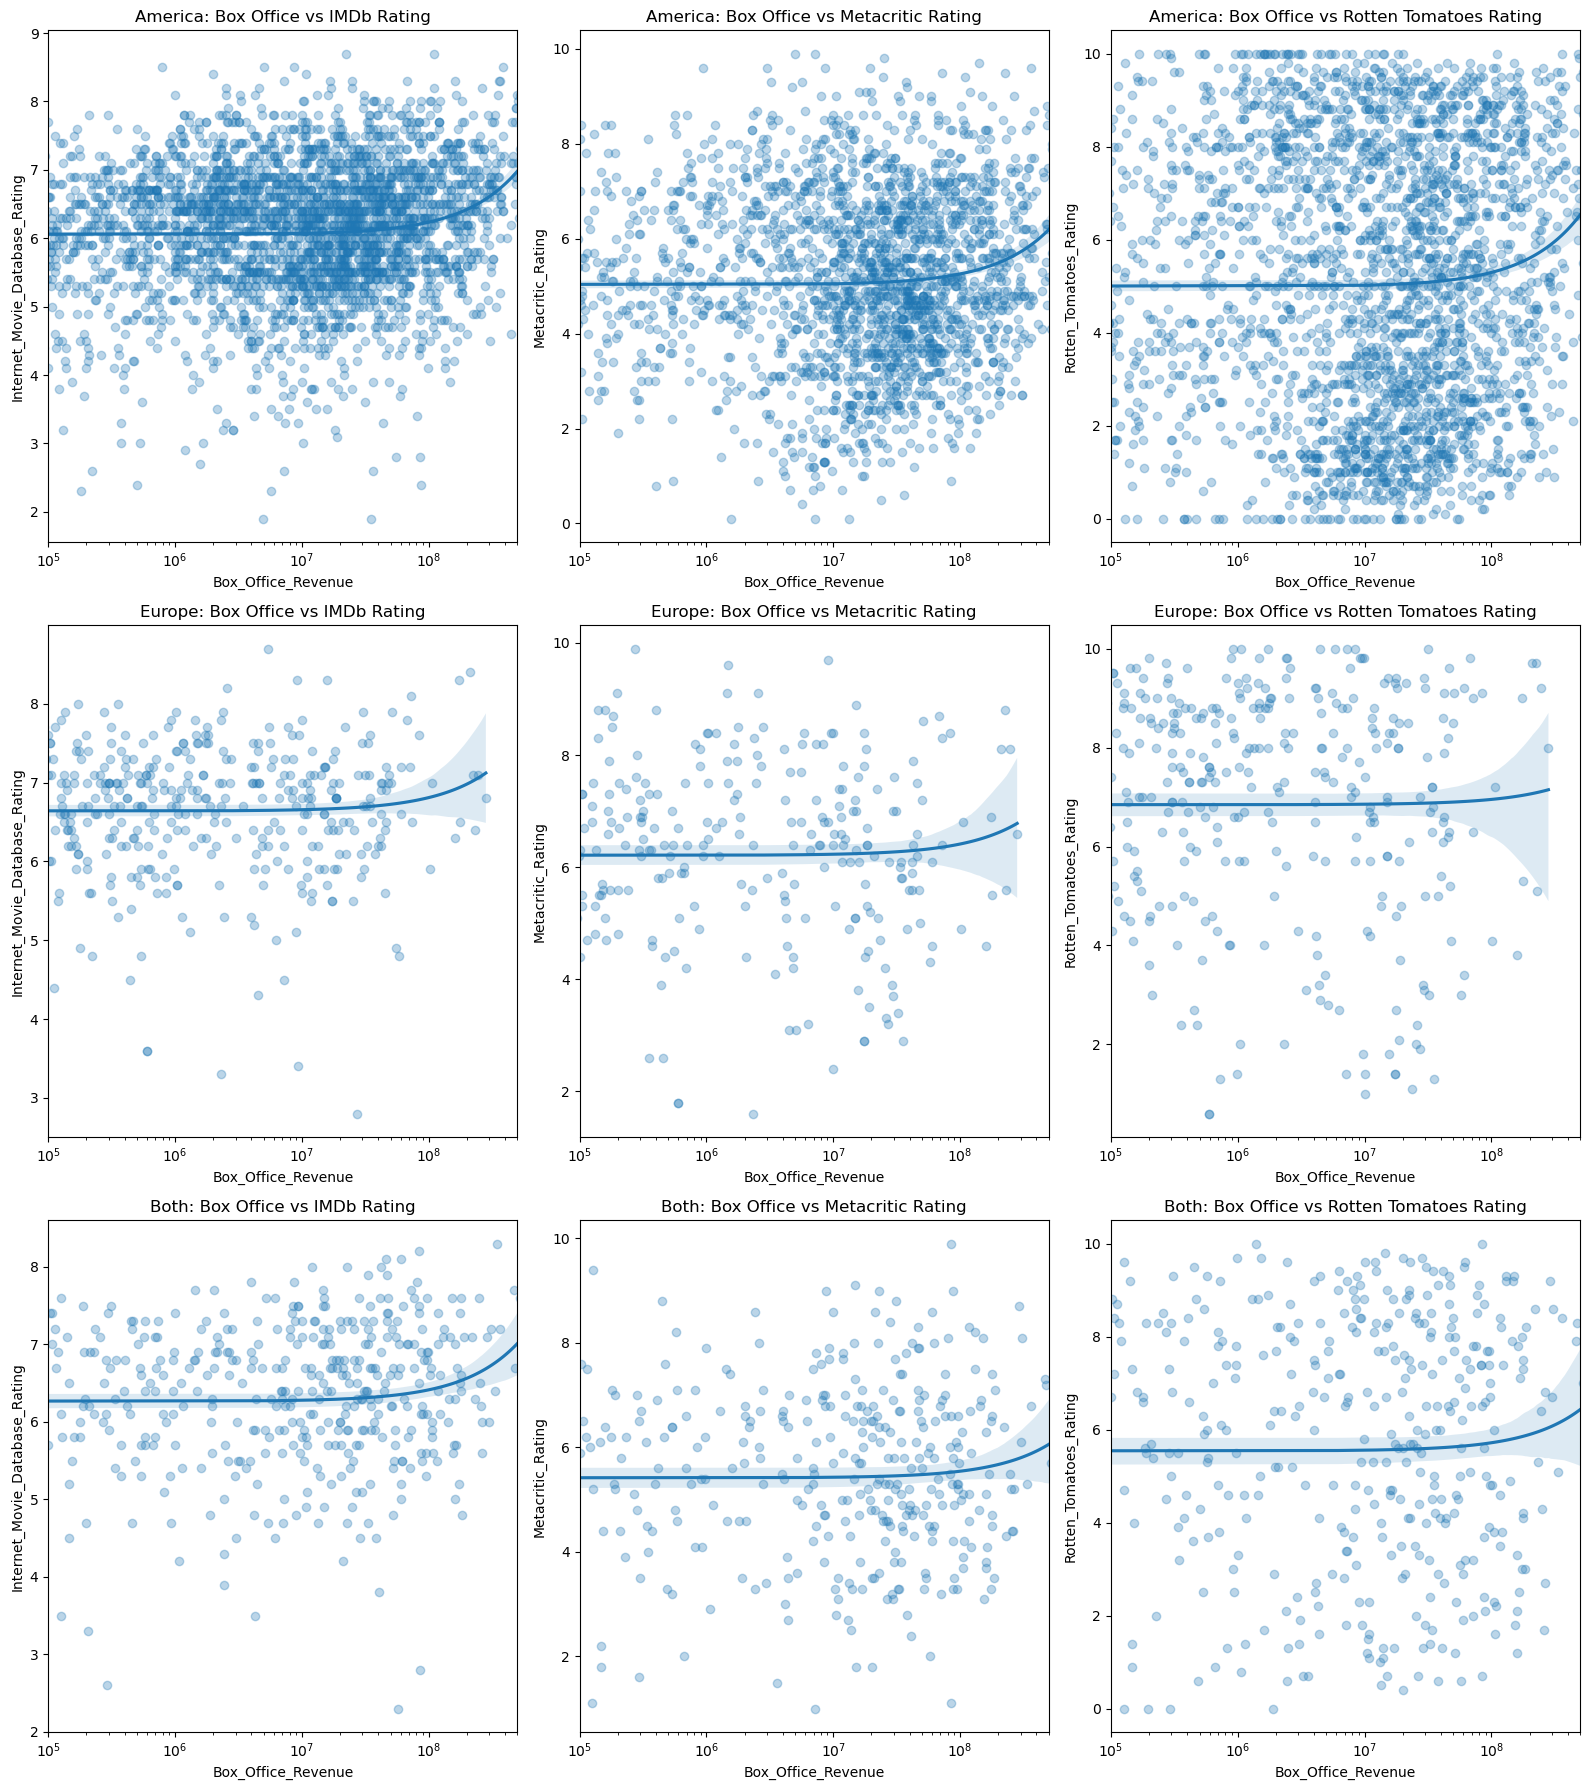

In [10]:
# filter data to include rows with non-null values for 'Box_Office_Revenue' and at least one rating
filtered_data = merged_movie_metadata.dropna(
    subset=['Box_Office_Revenue', 'Internet_Movie_Database_Rating', 'Rotten_Tomatoes_Rating', 'Metacritic_Rating'], 
    how='all'
)

# define the continents to analyze
continents = ['America', 'Europe', 'Both']

# create a figure with 3 subplots for each continent
fig, axes = plt.subplots(len(continents), 3, figsize=(16, 6 * len(continents)))

# iterate through each continent and create the regression plots
for i, continent in enumerate(continents):
    # filter data for the specific continent
    continent_data = filtered_data[filtered_data['Continents'].apply(lambda x: continent in x)]
    
    # plot 1: box office vs IMDb rating
    sns.regplot(
        data=continent_data, x='Box_Office_Revenue', y='Internet_Movie_Database_Rating', ax=axes[i, 0],
        scatter_kws={'alpha': 0.3}
    )
    axes[i, 0].set_xscale("log")
    axes[i, 0].set_xlim(1e5, 0.5e9)
    axes[i, 0].set_title(f'{continent}: Box Office vs IMDb Rating')

    # plot 2: box office vs Metacritic rating
    sns.regplot(
        data=continent_data, x='Box_Office_Revenue', y='Metacritic_Rating', ax=axes[i, 1],
        scatter_kws={'alpha': 0.3}
    )
    axes[i, 1].set_xscale("log")
    axes[i, 1].set_xlim(1e5, 0.5e9)
    axes[i, 1].set_title(f'{continent}: Box Office vs Metacritic Rating')

    # plot 3: box office vs Rotten Tomatoes rating
    sns.regplot(
        data=continent_data, x='Box_Office_Revenue', y='Rotten_Tomatoes_Rating', ax=axes[i, 2],
        scatter_kws={'alpha': 0.3}
    )
    axes[i, 2].set_xscale("log")
    axes[i, 2].set_xlim(1e5, 0.5e9)
    axes[i, 2].set_title(f'{continent}: Box Office vs Rotten Tomatoes Rating')

# adjust layout and display
plt.tight_layout()
plt.show()

In [11]:
# filter data to include rows with non-null values for 'Box_Office_Revenue' and at least one rating
filtered_data = merged_movie_metadata.dropna(
    subset=['Box_Office_Revenue', 'Internet_Movie_Database_Rating', 'Rotten_Tomatoes_Rating', 'Metacritic_Rating'], 
    how='all'
)

# define continents and rating types for analysis
continents = ['America', 'Europe', 'Both']
ratings = {
    'Internet Movie Database': 'Internet_Movie_Database_Rating',
    'Rotten Tomatoes': 'Rotten_Tomatoes_Rating',
    'Metacritic': 'Metacritic_Rating'
}

# calculate Spearman correlation and p-value for each rating and continent
correlations = [
    {
        'Continent': continent,
        'Score Type': score_type,
        'Spearman Correlation': (corr := spearmanr(
            filtered_data[filtered_data['Continents'].apply(lambda x: continent in x)]['Box_Office_Revenue'],
            filtered_data[filtered_data['Continents'].apply(lambda x: continent in x)][rating_col],
            nan_policy='omit'
        )[0]),
        'p-value': (p_val := spearmanr(
            filtered_data[filtered_data['Continents'].apply(lambda x: continent in x)]['Box_Office_Revenue'],
            filtered_data[filtered_data['Continents'].apply(lambda x: continent in x)][rating_col],
            nan_policy='omit'
        )[1]),
        'Significance': 'YES' if p_val < 0.05 else 'NO'
    }
    for continent in continents
    for score_type, rating_col in ratings.items()
]

# create a DataFrame to store the results
correlation_df = pd.DataFrame(correlations)

# display the correlation table
display(correlation_df)


Continent               Score Type  Spearman Correlation       p-value  \
0   America  Internet Movie Database              0.136595  3.865323e-15   
1   America          Rotten Tomatoes              0.024566  1.936836e-01   
2   America               Metacritic              0.066588  1.610712e-03   
3    Europe  Internet Movie Database              0.013382  7.635063e-01   
4    Europe          Rotten Tomatoes             -0.001806  9.699068e-01   
5    Europe               Metacritic              0.048977  3.751512e-01   
6      Both  Internet Movie Database              0.122589  9.160448e-03   
7      Both          Rotten Tomatoes              0.058265  2.328888e-01   
8      Both               Metacritic              0.071128  1.715840e-01   

  Significance  
0          YES  
1           NO  
2          YES  
3           NO  
4           NO  
5           NO  
6          YES  
7           NO  
8           NO

## Nomination Awards analysis
Do European comedies receive more nominations for awards than American comedies?

In [12]:
# calculate statistics for 'Nomination_Awards' grouped by continents
nominations_stats = merged_movie_metadata.groupby('Continents')['Nomination_Awards'].agg(
    ['mean', 'median', 'std', 'count', 'sum', 'max', 'min', 'var']
)
display(nominations_stats)

# calculate and display proportions for America and Europe
total_count = nominations_stats['count'].sum()
print(f"Proportion of America: {nominations_stats.loc["['America']", 'count'] / total_count:.2%}")
print(f"Proportion of Europe: {nominations_stats.loc["['Europe']", 'count'] / total_count:.2%}")

# filter the data for America and Europe
data_america = merged_movie_metadata[
    merged_movie_metadata['Continents'].apply(lambda x: 'America' in x)
]
data_europe = merged_movie_metadata[
    merged_movie_metadata['Continents'].apply(lambda x: 'Europe' in x)
]

mean  median        std  count    sum  max  min         var
Continents                                                                  
['America']  2.556719     0.0  10.794714   8595  21975  408    0  116.525844
['Both']     6.200935     2.0  13.582077    642   3981  133    0  184.472823
['Europe']   2.384615     0.0   7.810550   2444   5828  232    0   61.004692

Proportion of America: 73.58%
Proportion of Europe: 20.92%


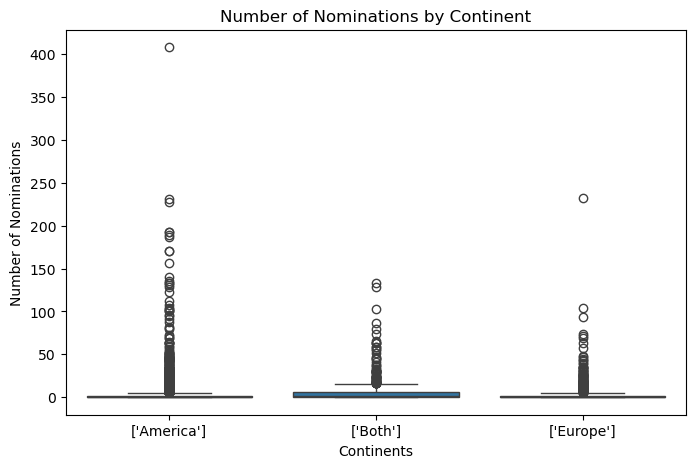

In [13]:
# create a boxplot to visualize the number of nominations by continent
plt.figure(figsize=(8, 5))
sns.boxplot(data=merged_movie_metadata, x='Continents', y='Nomination_Awards')

# add a title and axis labels
plt.title('Number of Nominations by Continent')
plt.xlabel('Continents')
plt.ylabel('Number of Nominations')

# display
plt.show()

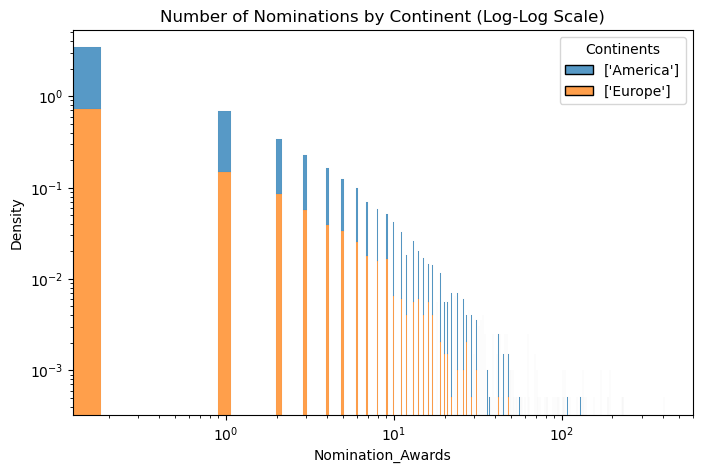

In [14]:
# create a histogram to visualize the number of nominations by continent (excluding 'Both')
plt.figure(figsize=(8, 5)) 
sns.histplot(
    data=merged_movie_metadata[merged_movie_metadata['Continents'] != "['Both']"],
    x='Nomination_Awards',
    hue='Continents',
    multiple='stack',
    stat='density'
)

# set the title and adjust scales for better visualization
plt.title('Number of Nominations by Continent (Log-Log Scale)')
plt.yscale('log')
plt.xscale('log')

# display
plt.show()

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Alpha for America films: 2.44
Alpha for Europe films: 3.05


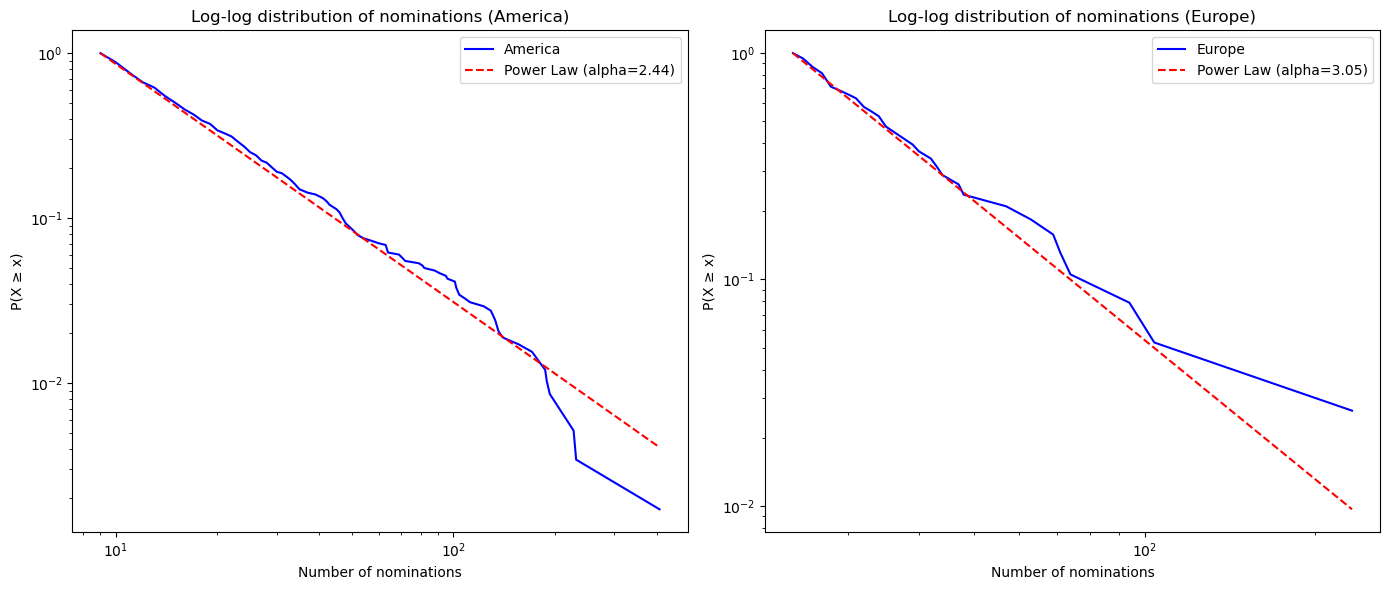

In [15]:
# extract and drop NaN values for nomination data
nominations = {
    'America': data_america['Nomination_Awards'].dropna(),
    'Europe': data_europe['Nomination_Awards'].dropna()
}

# fit power law distributions and store results
fit_results = {
    region: powerlaw.Fit(data) for region, data in nominations.items()
}

# calculate and display alpha values
for region, fit in fit_results.items():
    alpha = fit.power_law.alpha
    print(f"Alpha for {region} films: {alpha:.2f}")

# plot the log-log graphs to visualize the fits
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, (region, fit) in zip(axes, fit_results.items()):
    # plot empirical data and fitted power law
    fit.plot_ccdf(ax=ax, color='b', label=region)
    fit.power_law.plot_ccdf(ax=ax, color='r', linestyle='--', label=f'Power Law (alpha={fit.power_law.alpha:.2f})')

    # add title, labels, and legend
    ax.set_title(f'Log-log distribution of nominations ({region})')
    ax.set_xlabel('Number of nominations')
    ax.set_ylabel('P(X ≥ x)')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
# calculate the geometric mean of nominations for each continent, avoiding zero values by adding 1
geo_means = {
    "America": gmean(data_america['Nomination_Awards'] + 1) - 1,
    "Europe": gmean(data_europe['Nomination_Awards'] + 1) - 1
}

# display the results
for region, geo_mean in geo_means.items():
    print(f"Geometric mean of nominations for {region} comedy films: {geo_mean:.2f}")

Geometric mean of nominations for America comedy films: 0.76
Geometric mean of nominations for Europe comedy films: 0.85


In [17]:
# calculate the proportion of comedy films with at least one nomination for each region
proportions = {
    "America": (data_america['Nomination_Awards'] > 0).mean(),
    "Europe": (data_europe['Nomination_Awards'] > 0).mean()
}

# display the results
for region, proportion in proportions.items():
    print(f"Proportion of {region} comedy films with at least one nomination: {proportion:.2%}")

Proportion of America comedy films with at least one nomination: 37.74%
Proportion of Europe comedy films with at least one nomination: 41.16%


When comparing these proportions, European comedies seem slightly more appreciated (41.16% have at least one nomination) than American comedies (37.74%). However, this only reflects a measure based on nominations and does not take into account other factors such as audience scores or box office performance. For a more accurate conclusion, other criteria should be analyzed, and potential outliers in the data should be excluded.

We now remove outliers

In [18]:
from src.utils.data_utils import remove_outliers

# clean data by removing null 'Nomination_Awards' values
data_america_cleaned = data_america[data_america['Nomination_Awards'].notna()]
data_europe_cleaned = data_europe[data_europe['Nomination_Awards'].notna()]


# remove outliers for both regions
data_america_cleaned = remove_outliers(data_america_cleaned, 'Nomination_Awards')
data_europe_cleaned = remove_outliers(data_europe_cleaned, 'Nomination_Awards')

# calculate the statistics for each region after outlier removal
new_nominations_stats_america = data_america_cleaned['Nomination_Awards'].describe()
new_nominations_stats_europe = data_europe_cleaned['Nomination_Awards'].describe()

In [ ]:
# combine data for America and Europe, adding a 'Continent' column
combined_data = pd.concat([
    data_america_cleaned.assign(Continent='America'),
    data_europe_cleaned.assign(Continent='Europe')
])

# create a violin plot using Plotly
fig = px.violin(
    combined_data, 
    x='Continent', y='Nomination_Awards', color='Continent',
    box=True, points='all', hover_data=combined_data.columns,
    title='Nomination Distribution by Continent',
    labels={'Nomination_Awards': 'Number of Nominations', 'Continent': 'Continent'}
)

# update layout for better aesthetics
fig.update_layout(
    template='plotly_dark',
    title_text='Nomination Distribution by Continent',
    title_font_size=20,
    legend_title_text='Continent',
    xaxis_title='Continent',
    yaxis_title='Number of Nominations',
    font_size=12
)

# display
fig.show()

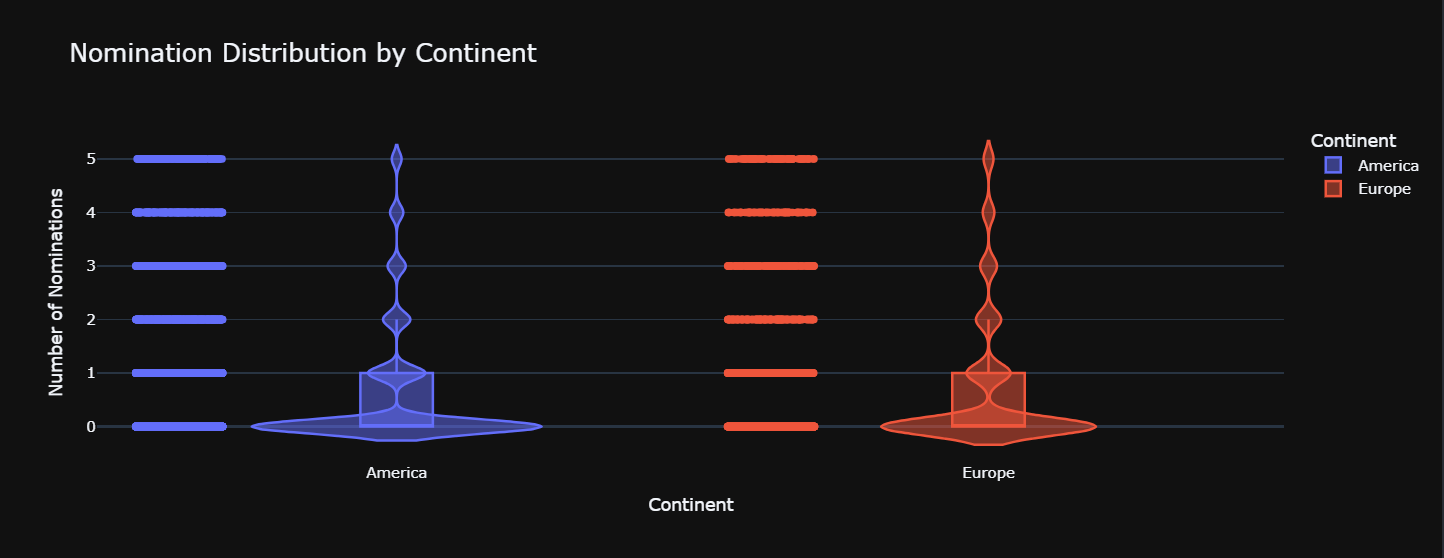

In [20]:
# perform the Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(
    data_america_cleaned['Nomination_Awards'], 
    data_europe_cleaned['Nomination_Awards'], 
    alternative='two-sided'
)
print(f"Mann-Whitney U statistic: {u_statistic}")
print(f"P-value: {p_value:.4f}")


Mann-Whitney U statistic: 7991598.5
P-value: 0.0017


In [ ]:
# calculate means and confidence intervals
mean_america = new_nominations_stats_america['mean']
mean_europe = new_nominations_stats_europe['mean']
std_america = new_nominations_stats_america['std']
std_europe = new_nominations_stats_europe['std']
count_america = new_nominations_stats_america['count']
count_europe = new_nominations_stats_europe['count']

# calculate 95% confidence intervals
ci_america = 1.96 * (std_america / np.sqrt(count_america))
ci_europe = 1.96 * (std_europe / np.sqrt(count_europe))

# create an interactive bar plot with error bars
fig = go.Figure(
    data=[
        go.Bar(
            x=['America', 'Europe'],
            y=[mean_america, mean_europe],
            error_y=dict(type='data', array=[ci_america, ci_europe], visible=True),
            marker_color=['blue', 'orange']
        )
    ]
)

# update plot layout
fig.update_layout(
    title='Nomination Mean by Continent',
    xaxis_title='Continent',
    yaxis_title='Mean Nominations',
    template='plotly_white',
    width=600,  # reduced width
    height=400  # adjusted height for better aspect ratio
)

# display
fig.show()

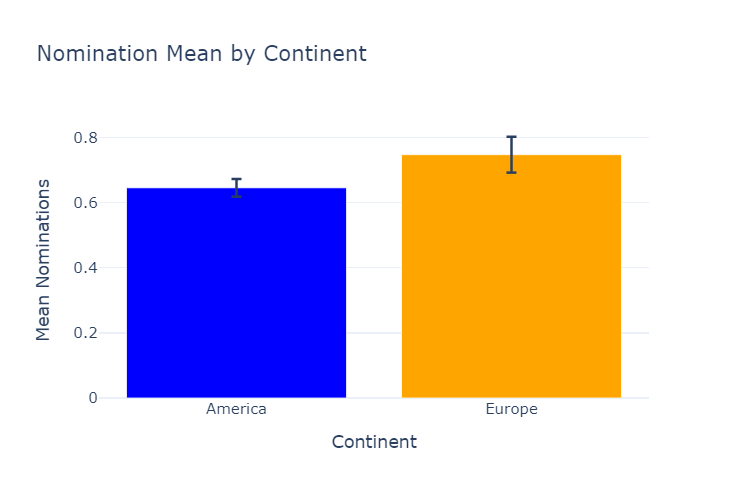

Statistically significant difference between the distributions of nominations for American and European comedies. European comedies receive, on average, more nominations than American comedies.

Creation of a new column for `data_cleaned_europe` and `data_cleaned_america`: **Critical Success** = (0.3 * Normalized IMDb) + (0.3 * Normalized Metacritic) + (0.2 * Normalized Nominations) + (0.2 * Normalized Awards)

## Factors Influencing Nominations

### Handle missing values by dropping them

In [22]:
# check for missing values in key columns
missing_values = merged_movie_metadata[[
    "Runtime", "imdbRating", "Rotten_Tomatoes_Rating", "Metacritic_Rating", 
    "Rated", "Nomination_Awards", "comedy_genres"
]].isnull().sum()

# drop rows with missing values in the specified key columns
data = merged_movie_metadata.dropna(subset=[
    "Runtime", "imdbRating", "Rated", "Nomination_Awards", 
    "comedy_genres", "Rotten_Tomatoes_Rating", "Metacritic_Rating"
])
print(f"Data shape after dropping missing values: {data.shape}")

# handle categorical variables with one-hot encoding
# encode 'Continents'
columns_continent = pd.get_dummies(data['Continents'], prefix='Continent')

# encode 'Rated'
columns_rated = pd.get_dummies(data['Rated'], prefix='Rated')

# encode 'comedy_genres'
# create binary columns for each unique comedy subgenre
unique_genres = set(genre for sublist in data['comedy_genres'] for genre in sublist)
columns_genres = pd.DataFrame({
    genre: data['comedy_genres'].apply(lambda x: genre in x) for genre in unique_genres
})

# concatenate the new columns to the main DataFrame
data = pd.concat([data, columns_continent, columns_rated, columns_genres], axis=1)
print(f"Data shape after adding encoded columns: {data.shape}")


Data shape after dropping missing values: (3121, 36)
Data shape after adding encoded columns: (3121, 73)


In [23]:
# rename specific columns for consistency
data.rename(columns={
    "Continent_['America']": "Continent_America",
    "Continent_['Both']": "Continent_Both",
    "Continent_['Europe']": "Continent_Europe"
}, inplace=True)

# filter data for America and Europe
data_america = data[data["Continent_America"] == True]
data_europe = data[data["Continent_Europe"] == True]

# select columns relevant for modeling
model_columns = ["Runtime", "imdbRating", "Nomination_Awards", "Rotten_Tomatoes_Rating", "Metacritic_Rating"]
data_america = data_america[model_columns]
data_europe = data_europe[model_columns]

### Splitting the Data into Training and Test Sets

In [24]:
# define the target variable (Y) and the feature matrix (X) for America and Europe
Y_america = data_america["Nomination_Awards"]
X_america = data_america.drop(columns=["Nomination_Awards"])

Y_europe = data_europe["Nomination_Awards"]
X_europe = data_europe.drop(columns=["Nomination_Awards"])

# split the data into training and testing sets
X_train_america, X_test_america, y_train_america, y_test_america = train_test_split(
    X_america, Y_america, test_size=0.2, random_state=42
)

X_train_europe, X_test_europe, y_train_europe, y_test_europe = train_test_split(
    X_europe, Y_europe, test_size=0.2, random_state=42
)

### Since box office revenues are skewed, we will apply a logarithmic transformation.

In [25]:
# standardize features using StandardScaler
scaler = StandardScaler()

# standardize data for America
X_train_scaled_america = scaler.fit_transform(X_train_america)  # fit and transform on training data
X_test_scaled_america = scaler.transform(X_test_america)        # transform test data using training stats

# standardize data for Europe
X_train_scaled_europe = scaler.fit_transform(X_train_europe)  # fit and transform on training data
X_test_scaled_europe = scaler.transform(X_test_europe)        # transform test data using training stats

# create Ridge regression models (adjust alpha for regularization strength)
regressor_america = Ridge(alpha=1.0)
regressor_europe = Ridge(alpha=1.0)

# fit the models
regressor_america.fit(X_train_scaled_america, y_train_america)
regressor_europe.fit(X_train_scaled_europe, y_train_europe)

# make predictions
y_pred_america = regressor_america.predict(X_test_scaled_america)
y_pred_europe = regressor_europe.predict(X_test_scaled_europe)

In [26]:
# calculate RMSE and R² scores for America
rmse_america = np.sqrt(mean_squared_error(y_test_america, y_pred_america))
r2_america = r2_score(y_test_america, y_pred_america)
print(f"RMSE (America): {rmse_america:.2f}, R²: {r2_america:.2f}")

# calculate RMSE and R² scores for Europe
rmse_europe = np.sqrt(mean_squared_error(y_test_europe, y_pred_europe))
r2_europe = r2_score(y_test_europe, y_pred_europe)
print(f"RMSE (Europe): {rmse_europe:.2f}, R²: {r2_europe:.2f}")

RMSE (America): 14.45, R²: 0.13
RMSE (Europe): 11.33, R²: 0.02


In [27]:
from src.utils.data_utils import get_sorted_coefficients

# get feature names after encoding
feature_names = X_america.columns

# compute and display coefficients for America
coefficients_america = get_sorted_coefficients(regressor_america, feature_names, "America")

# compute and display coefficients for Europe
coefficients_europe = get_sorted_coefficients(regressor_europe, feature_names, "Europe")


Top coefficients for America:


Feature  Coefficient
3       Metacritic_Rating     4.535667
1              imdbRating     2.080306
0                 Runtime     1.008777
2  Rotten_Tomatoes_Rating    -0.657930

Top coefficients for Europe:


Feature  Coefficient
3       Metacritic_Rating     5.464122
0                 Runtime     1.253357
1              imdbRating     1.212905
2  Rotten_Tomatoes_Rating    -0.872597

### General Conclusions

1. **Model Performance**:
   - **America**: Low R² (12.2%) and high error (RMSE > 108M), the model poorly explains the variance in box office performance.
   - **Europe**: Slightly better R² (16.8%), but the error remains significant (RMSE > 27M).

2. **Variable Importance**:
   - **America**:
     - IMDb ratings (**+**) and certain parental ratings (**AP: +**) have a significant positive impact.
     - "16+" films (**-**) and Rotten Tomatoes ratings (**-**) have a negative influence.
   - **Europe**:
     - "Not Rated" films (**-**) and "All Audiences" (**+**) play an important role.
     - IMDb ratings and movie length have a lesser positive impact compared to the U.S.

3. **Conclusion**:
   - The models do not capture box office trends well with the current variables.
   - Add relevant variables (budget, genre, release period).
   - Try non-linear models (Random Forest, Gradient Boosting) to capture complex relationships.

# Rated / Rating Analysis of Comedy Films

### Comparing Rated Categories in American and European Comedy Films


An analysis examining significant differences in `Rated` categories between American and European comedy films, focusing on specific themes previously identified.

In [28]:
# load the dataset
dataset = pd.read_csv('data/merged_movie_metadata.csv')

# drop duplicate rows and reset index
dataset_new = dataset.drop_duplicates().reset_index(drop=True)

# create a copy of the dataset for genre cleaning
dataset_genre_cleaned = dataset_new.copy()

# apply the determine_types function to classify genres in the 'Genres' column
dataset_genre_cleaned['Types'] = dataset_genre_cleaned['Genres'].apply(determine_types)

# simplify the 'Continents' column
dataset_genre_cleaned['Continents'] = dataset_genre_cleaned['Continents'].apply(
    lambda x: simplify_continent(ast.literal_eval(x))
)

In [29]:
# remove rows without 'imdbRating'
dataset_filtered = dataset.dropna(subset=['imdbRating'])

# keep only rows where 'Rated' is '16+' or '13+'
dataset_filtered = dataset_filtered[dataset_filtered['Rated'].isin(['16+', '13+'])]

# separate data into two DataFrames: 'America' and 'Europe' based on 'Continents'
dataset_america = dataset_filtered[dataset_filtered['Continents'].apply(lambda x: 'America' in x)]
dataset_europe = dataset_filtered[dataset_filtered['Continents'].apply(lambda x: 'Europe' in x)]

# keep only relevant columns
columns_to_keep = ['Continents', 'imdbRating', 'Rated']
dataset_america = dataset_america[columns_to_keep]
dataset_europe = dataset_europe[columns_to_keep]

# clean and standardize the 'Continents' column
clean_continents = lambda x: re.sub(r"[\[\]']", "", x)  # remove brackets and quotes
dataset_america['Continents'] = dataset_america['Continents'].apply(clean_continents).replace({'America': 'America'})
dataset_europe['Continents'] = dataset_europe['Continents'].apply(clean_continents).replace({'Europe': 'Europe'})

In [ ]:
# calculate the mean IMDb rating for each 'Rated' category for America and Europe
mean_ratings_america = dataset_america.groupby('Rated')['imdbRating'].mean()
mean_ratings_europe = dataset_europe.groupby('Rated')['imdbRating'].mean()

# create a bar plot using Plotly Graph Objects
fig = go.Figure()

# add bars for America
fig.add_trace(go.Bar(
    x=mean_ratings_america.index, 
    y=mean_ratings_america.values, 
    name='America'
))

# add bars for Europe
fig.add_trace(go.Bar(
    x=mean_ratings_europe.index, 
    y=mean_ratings_europe.values, 
    name='Europe'
))

# update layout for better appearance
fig.update_layout(
    title='Mean IMDb Rating by Rated Category for America and Europe',
    xaxis_title='Rated Category',
    yaxis_title='Mean IMDb Rating',
    template='plotly_white',
    barmode='group',  # group bars side by side
    legend_title_text='Continent'
)

# show the plot
fig.show()

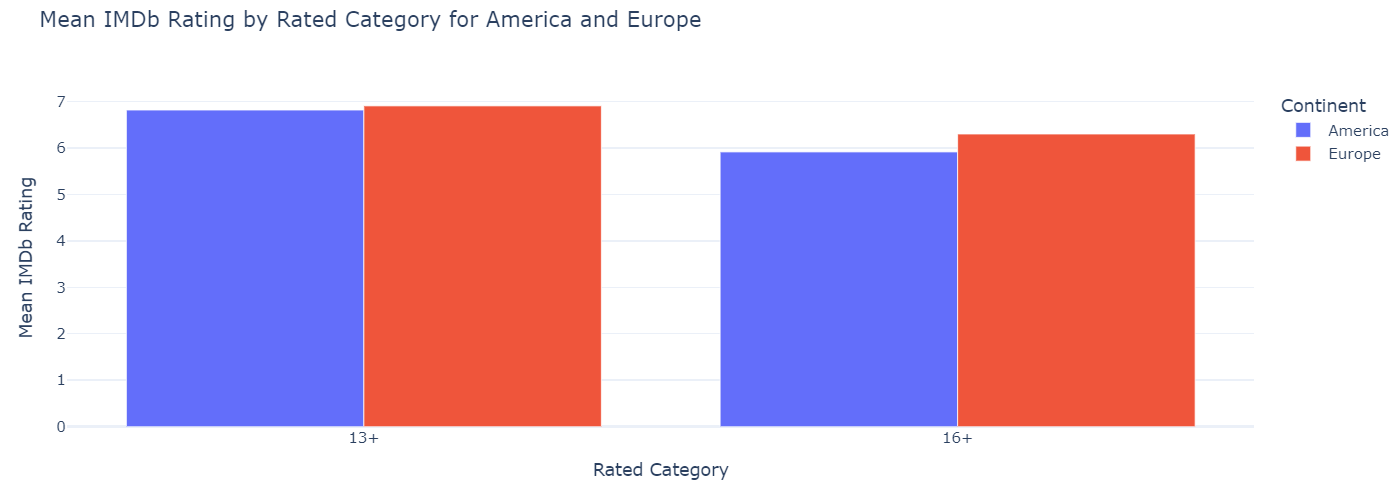

### Heatmap Analysis of Movie Ratings Across Comedy Subgenres



A visualization of IMDb scores across comedy subgenres, exploring the distribution of `Rated` categories and their relationship to audience preferences.

In [31]:
# load the dataset
dataset = pd.read_csv('data/merged_movie_metadata.csv')

# remove duplicate rows and reset the index
dataset_new = dataset.drop_duplicates().reset_index(drop=True)

# create a copy of the dataset for genre cleaning
dataset_genre_cleaned = dataset_new.copy()

# apply the determine_types function to classify genres
dataset_genre_cleaned['Types'] = dataset_genre_cleaned['Genres'].apply(determine_types)

# simplify the 'Continents' column by parsing and standardizing the values
dataset_genre_cleaned['Continents'] = dataset_genre_cleaned['Continents'].apply(
    lambda x: simplify_continent(ast.literal_eval(x))
)

In [32]:
# remove rows without 'imdbRating'
dataset_filtered = dataset_Genre_Cleaned.dropna(subset=['imdbRating'])

# keep only rows where 'Rated' is '16+', '13+', or 'All Audiences (TP)'
dataset_filtered = dataset_filtered[
    dataset_filtered['Rated'].isin(['16+', '13+', 'All Audiences (TP)'])
]

# separate data into two DataFrames: 'America' and 'Europe' based on 'Continents'
dataset_america = dataset_filtered[dataset_filtered['Continents'].apply(lambda x: 'America' in x)]
dataset_europe = dataset_filtered[dataset_filtered['Continents'].apply(lambda x: 'Europe' in x)]

# keep only relevant columns
columns_to_keep = ['Continents', 'imdbRating', 'Rated', 'Types']
dataset_america = dataset_america[columns_to_keep]
dataset_europe = dataset_europe[columns_to_keep]

# clean and standardize the 'Continents' column
clean_continents = lambda x: re.sub(r"[\[\]']", "", x)  # remove brackets and quotes
dataset_america['Continents'] = dataset_america['Continents'].apply(clean_continents).replace({'America': 'America'})
dataset_europe['Continents'] = dataset_europe['Continents'].apply(clean_continents).replace({'Europe': 'Europe'})


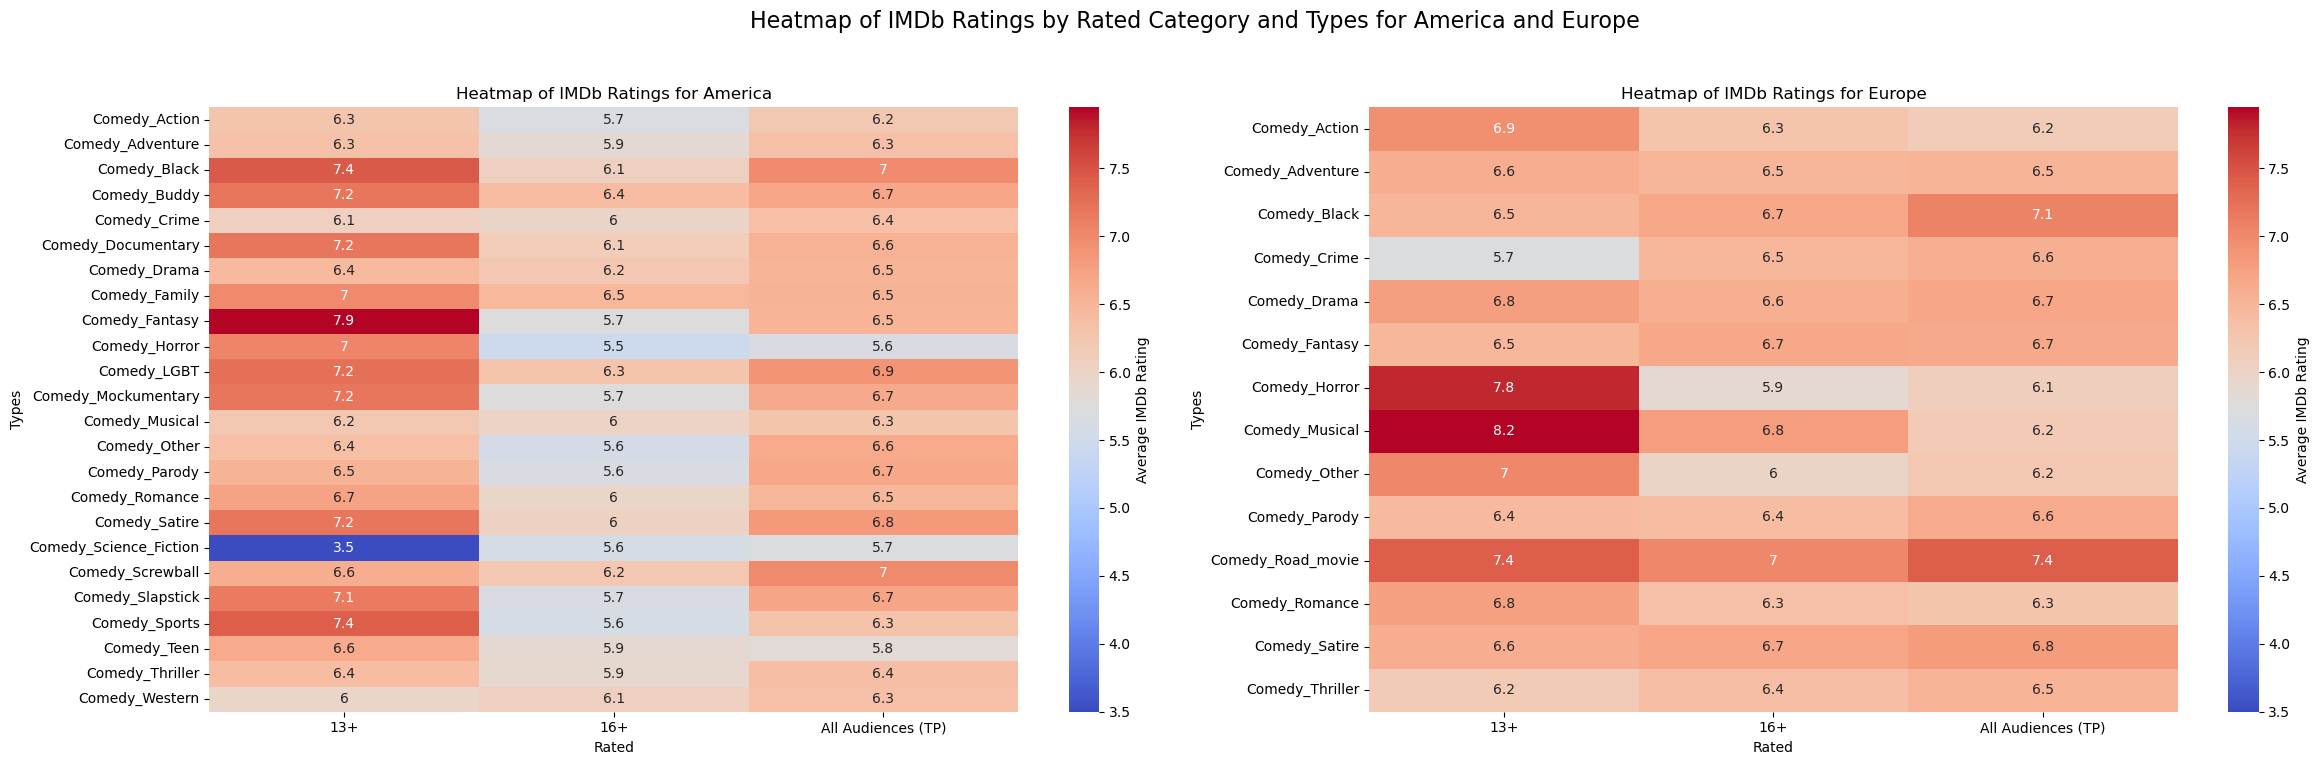

In [33]:
# explode the 'Types' column to separate multiple types into individual rows
dataset_america_exploded = dataset_america.explode('Types')
dataset_europe_exploded = dataset_europe.explode('Types')

# pivot the datasets to create matrices for the heatmaps
heatmap_data_america = dataset_america_exploded.pivot_table(
    index='Types', columns='Rated', values='imdbRating', aggfunc='mean'
)
heatmap_data_europe = dataset_europe_exploded.pivot_table(
    index='Types', columns='Rated', values='imdbRating', aggfunc='mean'
)

# remove rows with NaN values
heatmap_data_america.dropna(inplace=True)
heatmap_data_europe.dropna(inplace=True)

# define a colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

# plot the heatmap for America
sns.heatmap(
    heatmap_data_america, annot=True, cmap=cmap, 
    cbar_kws={'label': 'Average IMDb Rating'}, ax=ax1, 
    vmin=heatmap_data_america.values.min(), vmax=heatmap_data_america.values.max()
)
ax1.set_title('Heatmap of IMDb Ratings for America')
ax1.set_xlabel('Rated')
ax1.set_ylabel('Types')

# plot the heatmap for Europe
sns.heatmap(
    heatmap_data_europe, annot=True, cmap=cmap, 
    cbar_kws={'label': 'Average IMDb Rating'}, ax=ax2, 
    vmin=heatmap_data_america.values.min(), vmax=heatmap_data_america.values.max()
)
ax2.set_title('Heatmap of IMDb Ratings for Europe')
ax2.set_xlabel('Rated')
ax2.set_ylabel('Types')

# add a common title for both subplots
fig.suptitle(
    'Heatmap of IMDb Ratings by Rated Category and Types for America and Europe', 
    fontsize=16
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # adjust layout to fit the common title
plt.show()


In [34]:
# create an interactive heatmap for America
fig_america = px.imshow(
    heatmap_data_america,
    labels={"x": "Rated", "y": "Types", "color": "Average IMDb Rating"},
    x=heatmap_data_america.columns,
    y=heatmap_data_america.index,
    color_continuous_scale="RdBu_r",
    aspect="auto"
)
fig_america.update_layout(title="Interactive Heatmap of IMDb Ratings for America")

# create an interactive heatmap for Europe
fig_europe = px.imshow(
    heatmap_data_europe,
    labels={"x": "Rated", "y": "Types", "color": "Average IMDb Rating"},
    x=heatmap_data_europe.columns,
    y=heatmap_data_europe.index,
    color_continuous_scale="RdBu_r",
    aspect="auto"
)
fig_europe.update_layout(title="Interactive Heatmap of IMDb Ratings for Europe")

# show the interactive plots
fig_america.show()
fig_europe.show()


# Rating of Comedies : Critics vs Users

### Source of Ratings: Critics vs. Public

This table shows whether each rating source displays ratings from critics or the public.

| Rating Source                  | Type of Rating     | Description                                                                                       |
|--------------------------------|--------------------|---------------------------------------------------------------------------------------------------|
| **imdbRating**                 | Public             | Rating provided by IMDb users.                                                                    |
| **Rotten_Tomatoes_Rating**     | Critics            | Represents the **Tomatometer** score, an aggregated rating from professional critics.             |
| **Metacritic_Rating**          | Critics            | Aggregated rating from professional critics, provided by Metacritic.                              |

### Summary
- **Critics’ Ratings**: Rotten_Tomatoes_Rating (Tomatometer) and Metacritic_Rating.
- **Public Ratings**: imdbRating.




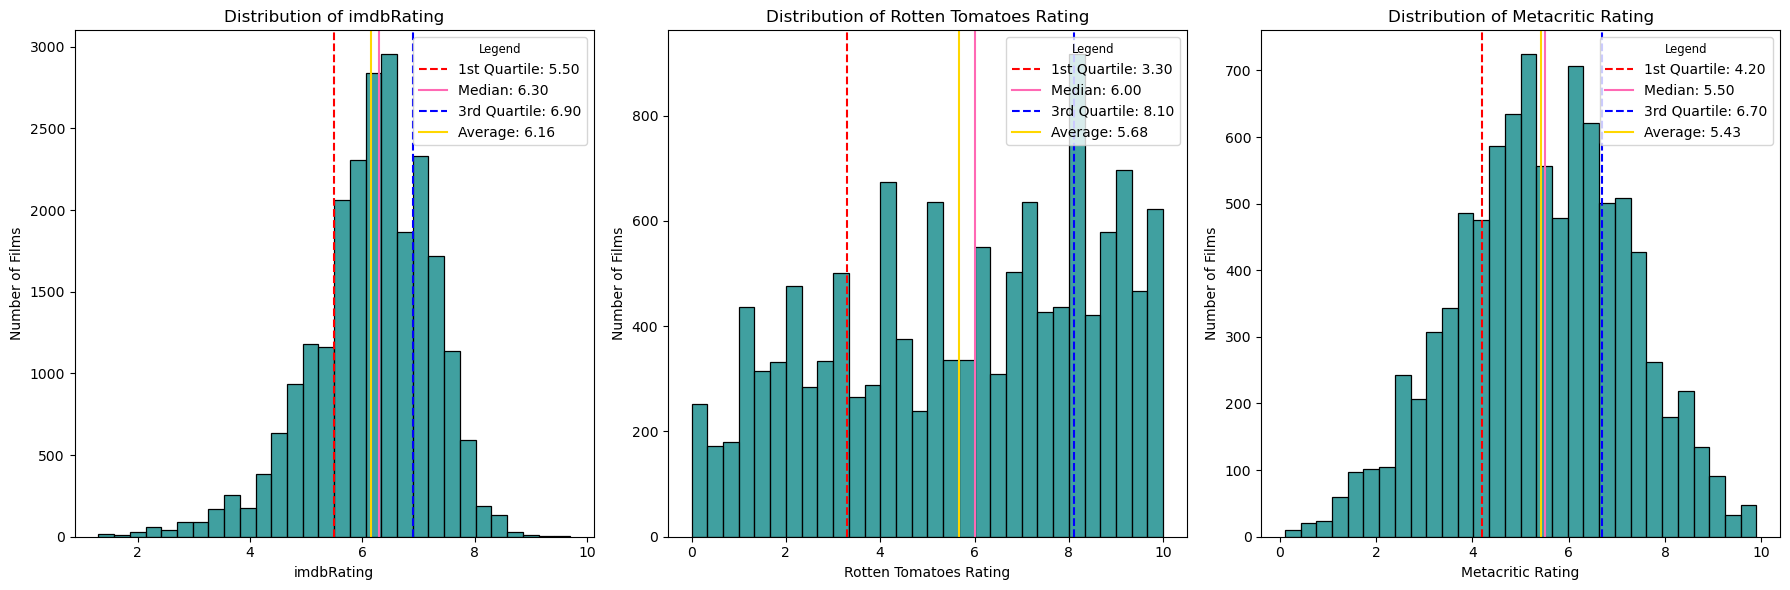

In [35]:
# explode the 'Types' column to have one type per row
exploded_dataset = dataset_Genre_Cleaned.explode('Types')

# define the ratings columns to analyze
ratings_columns = ['imdbRating', 'Rotten_Tomatoes_Rating', 'Metacritic_Rating']

# create subplots for the distributions
fig, axes = plt.subplots(1, len(ratings_columns), figsize=(18, 6))

for ax, rating in zip(axes, ratings_columns):
    # plot the histogram
    sns.histplot(
        exploded_dataset[rating].dropna(), bins=30, kde=False, color='teal', ax=ax
    )
    ax.set_title(f'Distribution of {rating.replace("_", " ")}')
    ax.set_xlabel(rating.replace("_", " "))
    ax.set_ylabel('Number of Films')

    # calculate quartiles, median, and average
    data = exploded_dataset[rating].dropna()
    quartiles = data.quantile([0.25, 0.5, 0.75])
    median = data.median()
    average = data.mean()

    # add vertical lines for quartiles, median, and average
    ax.axvline(quartiles[0.25], color='r', linestyle='--', label=f'1st Quartile: {quartiles[0.25]:.2f}')
    ax.axvline(median, color='hotpink', linestyle='-', label=f'Median: {median:.2f}')
    ax.axvline(quartiles[0.75], color='b', linestyle='--', label=f'3rd Quartile: {quartiles[0.75]:.2f}')
    ax.axvline(average, color='gold', linestyle='-', label=f'Average: {average:.2f}')

    # add the legend
    ax.legend(title='Legend', title_fontsize='small', loc='upper right')

# adjust layout for better spacing
plt.tight_layout()
plt.show()

### Are the distributions normal ?

In [36]:
# perform the Kolmogorov-Smirnov test for normality on each rating column
for rating in ratings_columns:
    # drop missing values for the current rating column
    data = dataset_Genre_Cleaned[rating].dropna().values

    # perform the KS test for normality
    ks_statistic, p_value = diagnostic.kstest_normal(data, dist='norm')

    # print the results
    print(f'Kolmogorov-Smirnov test for normality on {rating}:')
    print(f'  KS Statistic: {ks_statistic:.4f}')
    print(f'  P-Value: {p_value:.4f}\n')

Kolmogorov-Smirnov test for normality on imdbRating:
  KS Statistic: 0.0648
  P-Value: 0.0010

Kolmogorov-Smirnov test for normality on Rotten_Tomatoes_Rating:
  KS Statistic: 0.0834
  P-Value: 0.0010

Kolmogorov-Smirnov test for normality on Metacritic_Rating:
  KS Statistic: 0.0350
  P-Value: 0.0010



#### Kolmogorov-Smirnov Test for Normality on Movie Ratings

##### How the KS Test Works

1. **Define Hypotheses**:
   - **Null Hypothesis (H0)**: The data follows the specified distribution (e.g., normal distribution).
   - **Alternative Hypothesis (H1)**: The data does not follow the specified distribution.

2. **Calculate the KS Statistic**:
   - The KS statistic measures the maximum difference between the cumulative distribution of the sample data and the cumulative distribution of the normal distribution.
   - A larger KS statistic indicates a greater deviation between the sample data and the specified distribution.

3. **P-Value**:
   - The p-value tells us if the observed difference (measured by the KS statistic) is statistically significant.
   - A low p-value (typically < 0.05) means we can reject the null hypothesis and conclude that the data does not follow a normal distribution.
   - A high p-value (typically ≥ 0.05) means we fail to reject the null hypothesis, suggesting the data may follow a normal distribution.


### Results for Each Rating Source

| Rating Source                  | KS Statistic | P-Value | Interpretation                                                                                      |
|--------------------------------|--------------|---------|-----------------------------------------------------------------------------------------------------|
| **imdbRating**                 | 0.0648       | 0.0010  | The p-value of 0.001 suggests a significant deviation from normality, indicating this rating is not normally distributed. |
| **Rotten_Tomatoes_Rating**     | 0.0834       | 0.0010  | The highest KS statistic among all ratings, with a p-value of 0.001, suggesting a pronounced deviation from normality. |
| **Metacritic_Rating**          | 0.0350       | 0.0010  | Significant deviation from normality as indicated by the low p-value.                               |

### Summary

All ratings show p-values of 0.001, indicating that none of these datasets follow a normal distribution at a 0.05 significance level. The KS statistics for each rating source reinforce this conclusion, with **Rotten_Tomatoes_Rating** showing the highest deviation from normality. These results imply that assumptions of normality may not hold for analyses on these rating distributions.



## Analysis of Ratings: Do Critics Rate European Films More Severely Than Users? And the Same for American Films?



This analysis compares IMDb ratings (from users) with Rotten Tomatoes and Metacritic ratings (from critics) to determine if critics rate European and American films more severely than users.

### Methodology
- **Separate by Continent of Production**: The analysis is conducted separately for European and American films.
- **Combined Critic Ratings**: For each continent, Rotten Tomatoes and Metacritic ratings are combined into a single "Critics" group for analysis.
- **Statistical Tests**:
  - **Independent T-Test**: Used if both IMDb (user) and combined critics' ratings are normally distributed for each continent.
  - **Mann-Whitney U Test**: Used if the data is not normally distributed for each continent.
  
### Hypotheses

- **Null Hypothesis (H0)**: There is no difference between the ratings given by critics and users for films from each continent.
- **Alternative Hypothesis (H1)**: Critics rate films more severely than users for each continent, meaning critic ratings are lower than user ratings.

### Statistical Tests in Detail

#### Independent T-Test

The **Independent T-Test** compares the means of two independent groups (in this case, user ratings vs. critic ratings) to determine if there is a statistically significant difference between them.

- **Formula**:
  $
  t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}
  $
  Where:
  - $\bar{X}_1$ and $\bar{X}_2$ are the sample means for the two groups (users and critics).
  - $s_1^2$ and $s_2^2$ are the variances of the two groups.
  - $n_1$ and $n_2$ are the sample sizes of the two groups.

- **Assumptions**:
  - The data for each group should be normally distributed.
  - Variances of the two groups should be equal (if not, an adjusted version of the T-Test, known as Welch's T-Test, is used).

- **Interpretation of Results**:
  - If the p-value < 0.05, we reject the null hypothesis, suggesting a significant difference in mean ratings between critics and users.
  - If the p-value ≥ 0.05, we fail to reject the null hypothesis, indicating no significant difference in mean ratings.

#### Mann-Whitney U Test

If the data is not normally distributed, the **Mann-Whitney U Test** is a non-parametric alternative that compares the distributions of the two independent groups.

- **Formula**:
  $
  U = n_1 n_2 + \frac{n_1 (n_1 + 1)}{2} - R_1
  $
  Where:
  - $U$ is the test statistic.
  - $n_1$ and $n_2$ are the sample sizes of the two groups.
  - $R_1$ is the sum of ranks for the first group (users).

- **Interpretation of Results**:
  - If the p-value < 0.05, we reject the null hypothesis, indicating a significant difference in the distributions of ratings between critics and users.
  - If the p-value ≥ 0.05, we fail to reject the null hypothesis, suggesting no significant difference in distributions.

### Interpretation of Results
- **If p-value < 0.05**: Reject the null hypothesis, suggesting that critics rate films from that continent more severely than users.
- **If p-value ≥ 0.05**: Fail to reject the null hypothesis, indicating no significant difference between user and critic ratings for films from that continent.

### Summary

- **Independent T-Test** is used if ratings for each group (user and critic) are normally distributed.
- **Mann-Whitney U Test** is used as an alternative if data is not normally distributed.

In [37]:
from src.utils.data_utils import compare_ratings

# filter the dataset for the continents 'Europe' and 'America'
filtered_dataset = exploded_dataset[exploded_dataset['Continents'].isin(['Europe', 'America'])]

# separate user and critic ratings for Europe
europe_user_ratings = filtered_dataset.loc[filtered_dataset['Continents'] == 'Europe', 'imdbRating'].dropna()
europe_critic_ratings = filtered_dataset.loc[filtered_dataset['Continents'] == 'Europe', ['Rotten_Tomatoes_Rating', 'Metacritic_Rating']].dropna().values.flatten()

# separate user and critic ratings for America
america_user_ratings = filtered_dataset.loc[filtered_dataset['Continents'] == 'America', 'imdbRating'].dropna()
america_critic_ratings = filtered_dataset.loc[filtered_dataset['Continents'] == 'America', ['Rotten_Tomatoes_Rating', 'Metacritic_Rating']].dropna().values.flatten()

# run the test for Europe
compare_ratings(europe_user_ratings, europe_critic_ratings, "European")

# run the test for America
compare_ratings(america_user_ratings, america_critic_ratings, "American")


Mann-Whitney U Test Results for European Films:
P-Value: 0.9999999999998804
Result: No significant difference between critics' and users' ratings.

Mann-Whitney U Test Results for American Films:
P-Value: 6.653236467147125e-192
Result: Critics rate films more severely than users (significant difference).


### Summary of Mann-Whitney U Test Results: Do Critics Rate Films More Severely Than Users?

This table summarizes the results of the Mann-Whitney U Test comparing user and critic ratings for European and American films.

| Continent        | Test Statistic  | P-Value                   | Interpretation                                                                                           |
|------------------|-----------------|---------------------------|----------------------------------------------------------------------------------------------------------|
| **European Films** | Mann-Whitney U | 0.9999999999998804        | No significant difference between critics' and users' ratings; critics and users rate European films similarly. |
| **American Films** | Mann-Whitney U | 6.65e-192                 | Significant difference; critics rate American films more severely than users.                             |

### Additional Notes
- **Warning**: The large sample size (N > 5000) may impact the accuracy of the p-values, as indicated by a warning from the test. However, the results remain interpretable, especially for indicating significant differences.


# Are European Comedies Juged Better Than American Comedies

In [38]:
# perform independent t-tests for each rating column between Europe and America
for rating in ratings_columns:
    # filter ratings for Europe and America, dropping NaN values
    europe_ratings = dataset_Genre_Cleaned.loc[dataset_Genre_Cleaned['Continents'] == 'Europe', rating].dropna()
    america_ratings = dataset_Genre_Cleaned.loc[dataset_Genre_Cleaned['Continents'] == 'America', rating].dropna()

    # perform the t-test
    t_stat, p_value = stats.ttest_ind(europe_ratings, america_ratings)

    # print the results
    print(f"T-test for {rating.replace('_', ' ')}:")
    print(f"  T-Statistic: {t_stat:.4f}")
    print(f"  P-Value: {p_value:.4f}\n")

T-test for imdbRating:
  T-Statistic: 9.2832
  P-Value: 0.0000

T-test for Rotten Tomatoes Rating:
  T-Statistic: 13.3560
  P-Value: 0.0000

T-test for Metacritic Rating:
  T-Statistic: 10.0863
  P-Value: 0.0000



## T-Test Analysis of Ratings by Continent of Production



This analysis compares the average ratings of comedies produced in Europe and America using an independent t-test to determine if there are statistically significant differences in ratings based on the continent of production.

### Results

| Rating Source                  | T-Test Statistic | P-Value               | Degrees of Freedom | Interpretation                                                                                      |
|--------------------------------|------------------|-----------------------|--------------------|-----------------------------------------------------------------------------------------------------|
| **imdbRating**                 | 9.283            | 1.97e-20              | 10,443             | Significant difference in IMDb ratings between European and American-produced comedies, suggesting differing rating patterns. |
| **Rotten_Tomatoes_Rating**     | 13.356           | 6.86e-40              | 4,260              | Strongest observed difference, with a very high t-statistic, showing marked rating variation based on the continent of production. |
| **Metacritic_Rating**          | 10.086           | 1.57e-23              | 2,842              | Significant difference in ratings between European and American-produced comedies, similar to Rotten Tomatoes.           |

### Summary

All rating sources demonstrate statistically significant differences between comedies produced in Europe and America. This suggests that the continent of production may strongly influence movie ratings on these platforms. With very low p-values (all well below 0.05), we can be confident that these differences are not due to random chance and reflect actual rating patterns that vary by continent of production.


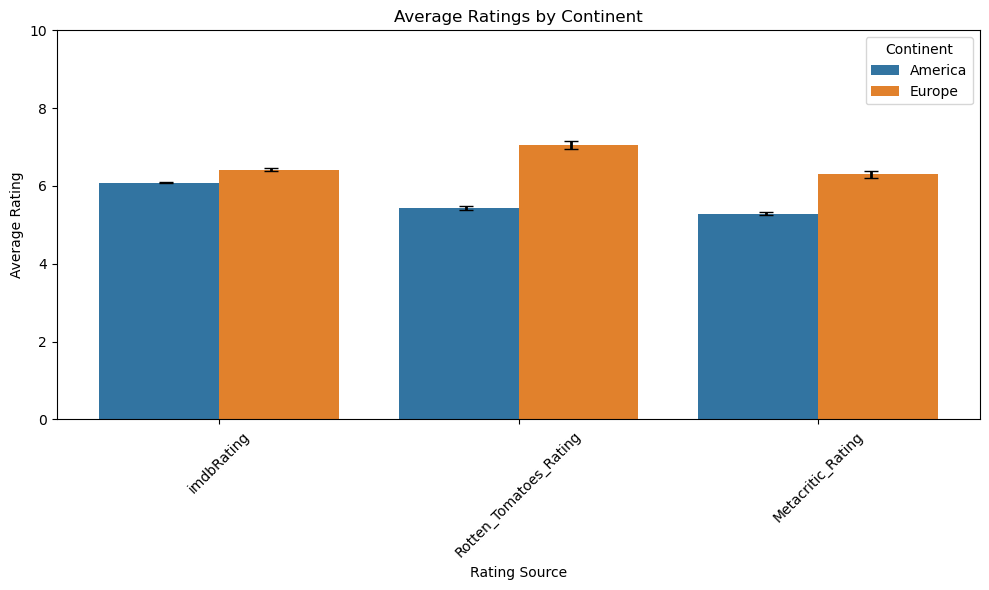

In [39]:
# filter the dataset for the continents 'Europe' and 'America'
filtered_dataset = exploded_dataset[exploded_dataset['Continents'].isin(['Europe', 'America'])]

# calculate the average rating per continent, ignoring NaNs
average_ratings = filtered_dataset.groupby('Continents')[ratings_columns].mean().reset_index()

# melt the dataframe for easier plotting with seaborn
melted_ratings = average_ratings.melt(id_vars='Continents', var_name='Rating_Source', value_name='Average_Rating')

# adjust Metascore for better comparison
melted_ratings.loc[melted_ratings['Rating_Source'] == 'Metascore', 'Average_Rating'] /= 10

# calculate confidence intervals, excluding NaNs
conf_intervals = filtered_dataset.groupby('Continents')[ratings_columns].agg(
    lambda x: stats.t.interval(0.95, len(x.dropna())-1, loc=np.mean(x.dropna()), scale=stats.sem(x.dropna()))
)

# plot the average ratings with confidence intervals
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Rating_Source', y='Average_Rating', hue='Continents', data=melted_ratings, errorbar=None)
plt.ylim([0, 10])
plt.title('Average Ratings by Continent')
plt.xlabel('Rating Source')
plt.ylabel('Average Rating')

# define bar width for alignment
bar_width = 0.35

# add error bars for each rating source and continent
for j, rating_source in enumerate(ratings_columns):
    for i, continent in enumerate(average_ratings['Continents']):
        lower_bound, upper_bound = conf_intervals.loc[continent, rating_source]
        y_value = average_ratings.loc[average_ratings['Continents'] == continent, rating_source].values[0]

        # adjust y_value for Metascore
        if rating_source == "Metascore":
            y_value /= 10

        # calculate x position for error bars
        x_pos = j + (i - 0.5) * bar_width

        # plot the error bars
        ax.errorbar(x=x_pos, y=y_value,
                    yerr=[[y_value - lower_bound], [upper_bound - y_value]],
                    fmt='none', c='black', capsize=5, lw=2)

# finalize plot
plt.legend(title='Continent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [40]:
# loop through each rating column and print confidence interval details
for rating in ratings_columns:
    # get confidence intervals for Europe and America
    europe_ci = conf_intervals.loc['Europe', rating]
    america_ci = conf_intervals.loc['America', rating]
    
    # print confidence interval details
    print(f"\n### {rating.replace('_', ' ')} ###")
    print(f"Europe Confidence Interval: ({europe_ci[0]:.2f}, {europe_ci[1]:.2f})")
    print(f"America Confidence Interval: ({america_ci[0]:.2f}, {america_ci[1]:.2f})")
    
    # check if intervals overlap and provide interpretation
    if europe_ci[0] > america_ci[1] or america_ci[0] > europe_ci[1]:
        print("Interpretation: The confidence intervals do not overlap, indicating a statistically significant difference.")
    else:
        print("Interpretation: The confidence intervals overlap, suggesting no statistically significant difference.")


### imdbRating ###
Europe Confidence Interval: (6.39, 6.45)
America Confidence Interval: (6.07, 6.10)
Interpretation: The confidence intervals do not overlap, indicating a statistically significant difference.

### Rotten Tomatoes Rating ###
Europe Confidence Interval: (6.95, 7.16)
America Confidence Interval: (5.37, 5.48)
Interpretation: The confidence intervals do not overlap, indicating a statistically significant difference.

### Metacritic Rating ###
Europe Confidence Interval: (6.20, 6.40)
America Confidence Interval: (5.25, 5.33)
Interpretation: The confidence intervals do not overlap, indicating a statistically significant difference.


## Confidence Interval Analysis of Movie Ratings by Continent of Production



This table summarizes the confidence intervals (CIs) for movie ratings of comedies produced in Europe and America across various rating sources. The non-overlapping confidence intervals indicate statistically significant differences in average ratings between the continents of production.

| Rating Source               | Europe CI                  | America CI                | Interpretation                                                                                                                                                             |
|-----------------------------|----------------------------|---------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **imdbRating**              | (6.39, 6.45)               | (6.07, 6.10)             | Non-overlapping intervals suggest a significant difference, with European-produced comedies rated slightly higher than American-produced comedies on IMDb.                                       |
| **Rotten_Tomatoes_Rating**  | (6.95, 7.16)               | (5.37, 5.48)             | Significant difference indicated by non-overlapping intervals, with European comedies receiving notably higher ratings on Rotten Tomatoes compared to American comedies.                     |
| **Metacritic_Rating**       | (6.20, 6.40)               | (5.25, 5.33)             | Non-overlapping intervals show a statistically significant difference, with European comedies rated higher than American comedies on Metacritic.                                         |

### Summary of Findings
- **Statistically Significant Differences**: All rating sources show non-overlapping confidence intervals between European and American comedies, indicating significant differences in average ratings based on the continent of production.
- **Higher Ratings for European Comedies**: European-produced comedies have consistently higher ratings across all platforms compared to American-produced comedies, reflecting potential cultural or perceptual differences in movie appreciation.
- **Implications**: These findings are essential for cross-continental comparisons of movie ratings, as production region appears to impact ratings and may reflect different preferences or rating standards across platforms.


# <h1 style="text-align:center; color: #32CD32;">AXE 2 : Narrative Themes and Movie Plots Analysis 📖🎥</h1>


In this axis, we aim at focusing on a more Natural Language Processing (NLP) strategy to process the CMU movie dataset.

In [41]:
# file paths
DATASET_FILEPATH = Path("data/merged_movie_metadata.csv")
PLOT_SUMMARIES_FILEPATH = Path("../MovieSummaries/plot_summaries.txt")

# load the dataset
df = pd.read_csv(DATASET_FILEPATH)

# keep only unique rows based on 'Wikipedia_ID'
df = df.drop_duplicates(subset=['Wikipedia_ID'])

# load plot summaries into a dictionary
plot_summaries = {}
with open(PLOT_SUMMARIES_FILEPATH, 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split('\t', 1)
        if len(parts) == 2:
            wiki_id, summary = parts
            plot_summaries[int(wiki_id)] = summary

# map plot summaries to the DataFrame
df['Plot_Summary_Base'] = df['Wikipedia_ID'].map(plot_summaries)

### Loading and Preparing Movie Plot Summaries

Our dataset includes two main sources for movie plot summaries:

1. **OMDB Data (Plot column)**: This source provides a brief summary of the movie plot in a few sentences.
2. **CMU Movie Summary Corpus (plot_summaries.txt)**: This file, obtained from the [CMU Movie Summary Corpus website](https://www.cs.cmu.edu/~ark/personas/), contains detailed plot summaries for a range of movies.

Since both sources may contain missing values for certain movies, we will combine the two to maximize coverage and ensure we have plot information for as many movies as possible. Below is a check to see how many values are missing in each plot source:

In [42]:
# check missing values in both plot sources
print(f"Total movies: {len(df)}")
print(f"Missing values in OMDB Plot column: {df['Plot'].isna().sum()}")
print(f"Missing values in CMU Plot Summary column: {df['Plot_Summary_Base'].isna().sum()}")

# movies missing both plot summaries
print(f"Movies missing both summaries: {(df['Plot'].isna() & df['Plot_Summary_Base'].isna()).sum()}")

Total movies: 11681
Missing values in OMDB Plot column: 423
Missing values in CMU Plot Summary column: 4076
Movies missing both summaries: 362


## Additionnal dataset

For our journey, we will need to retrieve an aditionnal dataset from the internet. We will get it from OMDB [Open Movie Database](https://www.omdbapi.com), an open API that allows to retrieve movie metadata from their IMDBId, or even simpler, from their title.

After getting an API key, we managed to query the database for $73'000$ movies out of the $\approx 83'000$ original movies of `movie_metadata.tsv` from CoreNLP.

The resulting `.json` file was merged with the original CoreNLP dataset, adding the following columns :

    ["Rated", "Director", "Writer", "Actors", "Plot", "Awards", "Poster", "Ratings", "Metascore", "imdbRating", "imdbVotes", "imdbID", "DVD", "Production", "Website", "Response", "totalSeasons", "Oscar", "Nomination_Awards", "Win_Awards", "Internet_Movie_Database_Rating", "Rotten_Tomatoes_Rating", "Metacritic_Rating"]

We can then process to our text-based analysis.

### Text Preprocessing for Movie Plots

To analyze movie plots, we need to process the text data to standardize and clean it. We perform several key steps in this process:

1. **Text selection** - For each movie, we prioritize plot summaries from the [CMU Movie Summary Corpus](https://www.cs.cmu.edu/~ark/personas/) because they tend to be richer in content. If a summary from this source is unavailable (i.e., a missing value), we use the summary from OMDB. If both sources are missing, the result will be marked as `NaN`.
   
2. **Tokenization** We split each plot summary into individual words (tokens).

3. **Stop words removal** Commonly used words that don’t contribute meaningful information (known as stop words) are removed. Examples of stop words include "the," "is," "and," "in," "to," etc.

4. **Lemmatization** Each word is reduced to its base or root form. For instance, words like "running," "runs," and "ran" are all converted to "run". This helps improve the accuracy of our analysis by avoiding duplicates in different forms. This process is called.

5. **Frequency analysis** We analyze the frequency and type of words used.


In [43]:
# text Preprocessing
from src.utils.data_utils import tok_by_region

# tokenize plots by region
tokenized_plots_america = tok_by_region(df, 'America')
tokenized_plots_europe = tok_by_region(df, 'Europe')
tokenized_plots_both = tok_by_region(df, 'Both')

We now want to see the most frequently used words in movie plots across our three regions: **America**, **Europe**, and **Both**. We use a `Counter` to count occurrences of each word in the tokenized plots for each region.

In [44]:
# word Counts
from src.utils.data_utils import get_word_count

word_count_america = get_word_count(tokenized_plots_america)
word_count_europe = get_word_count(tokenized_plots_europe)
word_count_both = get_word_count(tokenized_plots_both)

print("Top 10 words in America:", word_count_america.most_common(10))
print("\nTop 10 words in Europe:", word_count_europe.most_common(10))
print("\nTop 10 words in Both:", word_count_both.most_common(10))

Top 10 words in America: [('get', 6140), ('find', 5148), ('go', 5088), ('one', 4688), ('back', 4513), ('take', 4335), ('new', 3921), ('tell', 3897), ('friend', 3740), ('two', 3736)]

Top 10 words in Europe: [('one', 895), ('film', 878), ('get', 846), ('find', 821), ('go', 774), ('life', 772), ('take', 734), ('two', 722), ('friend', 682), ('love', 634)]

Top 10 words in Both: [('find', 642), ('get', 574), ('go', 561), ('one', 544), ('take', 494), ('two', 459), ('back', 448), ('tell', 441), ('new', 408), ('film', 407)]


We now have the most frequently used words in each region’s plot summaries, but these results feel somewhat limited. To gain deeper insights, we’ll use the Stanford CoreNLP-processed summaries, which provide richer linguistic information.

These summaries, derived from `plot_summaries.txt`, have been processed with the [Stanford CoreNLP pipeline](https://stanfordnlp.github.io/CoreNLP/), a tool that performs advanced language processing tasks such as part-of-speech tagging, syntactic parsing, named entity recognition (NER), and coreference resolution. This additional information will allow us to analyze not only word frequency but also the context and roles of words within each summary. We will first extract the **POS tags**.

First, let's configure the folder where we store these summaries (not included in github due to the large space it takes) :

In [45]:
folder_path = Path("../corenlp_plot_summaries_augmented")

assert folder_path.exists(), "Must configure the correct path to corenlp_plot_summaries"

Then, let's see how many movies that have their summaries processed.

 > **Note :** originally, only ~7'000 movies were processed. We added 3'500 missing movies by processing their OMDB plot summaries instead. This was a bit of a headache and since this is preprocessing, the logic was moved inside `src/scripts/` to lighten the notebook. See [extract_ids_to_run_in_pipeline.py](src/scripts/extract_ids_to_run_in_pipeline.py) and [INTELLIJ_run_Stanford_Pipeline.xml](src/scripts/INTELLIJ_run_Stanford_Pipeline.xml) for details on how this was achieved.

In [46]:
# count matching folders/files
processed_ids = {f.stem.replace(".xml", "") for f in folder_path.glob("*.xml.gz")}
available_ids = set(df["Wikipedia_ID"].astype(str))
matching_files = [folder_path/f"{filename}.xml.gz" for filename in processed_ids.intersection(available_ids)]

print(f"Number of matching folders/files: {len(matching_files)}")
print(f"Number of unique Wiki id's: {df['Wikipedia_ID'].nunique()}")

Number of matching folders/files: 11319
Number of unique Wiki id's: 11681


### Filter using the POS fields

**POS (Part Of Speech) fields contains word metadata. It indicates whether the current word is a noun, a verb, an adjective, etc.**

[An example POS definition can be found here](https://en.wikipedia.org/wiki/Brown_Corpus#Part-of-speech_tags_used) :

We need to know what kind of fields we have in our files to extract the most useful ones for our analysis. To do so, and to avoid unzipping all the xml files to the computer, we can leverage bash tools and use this (non-optimized) command. However, even if this method is (quiet) efficient, it would still take a long time to process all the files. Since we use this command only to get a grasp of the POS fields, we executed it on a subset of files chosen randomly. We just replace "*xml.gz" with the first 5000 files after being sorted randomly.


```bash
    zcat  $(ls *.xml.gz | sort -R | head -n5000) | grep -oP "(?<=<POS>)[^<]+" | sort | uniq -c | sort -rn
```

How it works :
 - `$(ls *.xml.gz | sort -R | head -n5000)` returns 5000 randomly chosen filenames inside the current directory.
 - `zcat` displays the content of a .gz (gzipped) file as text
 - The output is piped to `grep` which extracts all the POS fields as strings : "(...) <POS>NN</POS> (...)" => "NN" 
 - The output is piped to `sort` which sorts this sequence of strings
 - The output is piped to `uniq` which prints each string only once, preceded with its number of occurences
 - The output is piped to `sort` which sorts the list of string occurences by descending order.


Which gives as output :

```text
     250061 NN
     185484 IN
     164548 NNP
     162675 DT
     116598 VBZ
      93384 ,
     [...]
```

We redirect the output to a file `data/POS_tokens.csv` and read it with pandas :



<Figure size 1000x600 with 0 Axes>

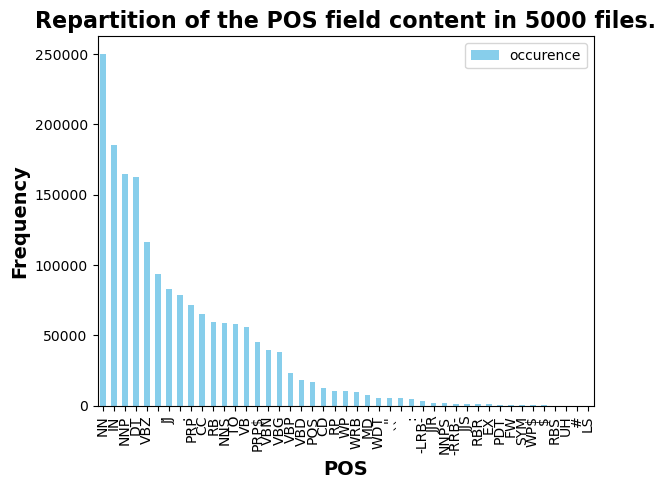

In [47]:
df_pos = pd.read_csv("data/POS_tokens.csv", sep=" ", header=None)
df_pos.columns = ["occurence", "token"]
plt.figure(figsize=(10, 6))
df_pos.plot(x='token', y='occurence', kind='bar', color='skyblue')
plt.title(f'Repartition of the POS field content in 5000 files.', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('POS', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Frequency', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xticks(rotation=90)
plt.show()

Now that we have a clear idea of the most commonly used POS tags, we can use this information to focus on the tags that will be most relevant and insightful for our analysis. 
Let's now see how many films in our dataset have gone through the Stanford CoreNLP pipeline:

### Running the CoreNLP pipeline on the OMDB plots summaries (fallback)

Out of a total of 11'681 films, 11'319 have been processed through the Stanford CoreNLP pipeline.

To work with the Stanford CoreNLP-processed data, we have defined several utility functions in the file `data_utils.py`:

1. **`get_sentence_word_metadata`**:
   - This function retrieves metadata from the CoreNLP pipeline output for a given movie ID. 
   - It extracts tokens, their lemmas, and part-of-speech (POS) tags from `.xml.gz` files.

2. **`filter_words_by_pos`**:
   - This function filters tokens based on specified POS tags, allowing us to focus on particular types of words, such as nouns, verbs, or adjectives.

3. **`filter_words_by_pos_ngram`**:
   - This function generates n-grams (sequences of n consecutive words) from the tokenized data, filtered by the specified POS tags. It is useful for capturing patterns and contexts in the text.

We also define three sets of ids for each region ("Europe", "America" or both of them).

In [48]:
# define Regions
region_ids = {
    "America": set(df[df['Continents'].str.contains("America")]['Wikipedia_ID'].astype(str)),
    "Europe": set(df[df['Continents'].str.contains("Europe")]['Wikipedia_ID'].astype(str)),
    "Both": set(df[df['Continents'].str.contains("Both")]['Wikipedia_ID'].astype(str))
}

After we've successfully extracted the words we wanted, the next step is to visualize them. To do this, we will use a word cloud visualization to display the most frequent words. In a word cloud, word size represent their frequency of occurence. This gives immediately a grasp of the word occurences.

Using the POS tags defined above, we can group the tags into specific categories (e.g., nouns, verbs, adjectives) to filter tokens for our word cloud.

In [49]:
# POS Tags Groups
noun_tags = ['NN', 'NNA', 'NNC', 'NNS', 'NNP', 'NNPS']
verb_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBS', 'VBZ']
adjective_tags = ['JJ', 'JJR', 'JJS', 'JJC', 'JJA', 'JJF', 'JJM']

# word cloud mask images
americas_mask = np.array(Image.open("src/ressource/Location_North_America.png"))
europe_mask = np.array(Image.open("src/ressource/Location_Europe.png"))
both_mask = np.array(Image.open("src/ressource/Location_Both.png"))

# loading the datasets for the splits
Data_Biggest_America = pd.read_csv("data/data_p3/Data_Biggest_America.csv")
Data_Biggest_Both = pd.read_csv("data/data_p3/Data_Biggest_Both.csv")
Data_Biggest_Europe = pd.read_csv("data/data_p3/Data_Biggest_europe.csv")
Data_Biggest_Gap_diff_Eu_Am = pd.read_csv("data/data_p3/Data_Biggest_Gap_diff_Eu_Am.csv")
Data_Smallest_Gap_diff_Eu_Am = pd.read_csv("data/data_p3/Data_Smallest_Gap_diff_Eu_Am.csv")

# dictionary for the splits
dataset_subsets = {
    "Biggest_America": Data_Biggest_America,
    "Biggest_Both": Data_Biggest_Both,
    "Biggest_Europe": Data_Biggest_Europe,
    "Biggest_Gap_diff_Eu_Am": Data_Biggest_Gap_diff_Eu_Am,
    "Smallest_Gap_diff_Eu_Am": Data_Smallest_Gap_diff_Eu_Am,
}

To create a customized word cloud for a specific region or subset of the data, we use the `generate_word_cloud_on_subset` function. This function allows you to filter data by region, apply POS tagging (e.g., focusing on nouns), and customize the word cloud's appearance, such as using region-specific masks and n-gram configurations. The output can be displayed directly or saved to a specified folder.


#### Parameters:
- **`region`**: Specifies the region to filter the data (e.g., "Europe").
- **`pos_tags`**: Part-of-speech tags to focus on (e.g., nouns).
- **`title`**: Title for the word cloud visualization (e.g., "Nouns in Europe").
- **`folder_path`**: Path where the output will be saved (optional).
- **`region_ids`**: IDs corresponding to the selected region.
- **`dataset_subsets`**: Subsets of the dataset to process.
- **`mask_image`**: Mask for shaping the word cloud (e.g., a region-specific mask like `europe_mask`).
- **`sample_output`**: Boolean flag to sample the output for visualization.
- **`ngrams`**: Number of n-grams to include in the word cloud.
- **`subset_name`**: Name of the dataset subset being processed. If no `subset_name` is provided, the function will process the full dataset without applying any subset filter.
- **`store_to`**: Path to save the word cloud (optional).
- **`dpi`**: Resolution of the output image (e.g., 300 dpi).

Processing Europe - Nouns in Europe: 100%|██████████| 99/99 [00:01<00:00, 86.09it/s]



Sample of filtered words for Europe - Nouns in Europe:
[('film', 61), ('war', 50), ('soldiers', 37), ('Jan', 33), ('Elwood', 32), ('life', 31), ('man', 31), ('Javier', 31), ('War', 30), ('Barbarella', 30)]


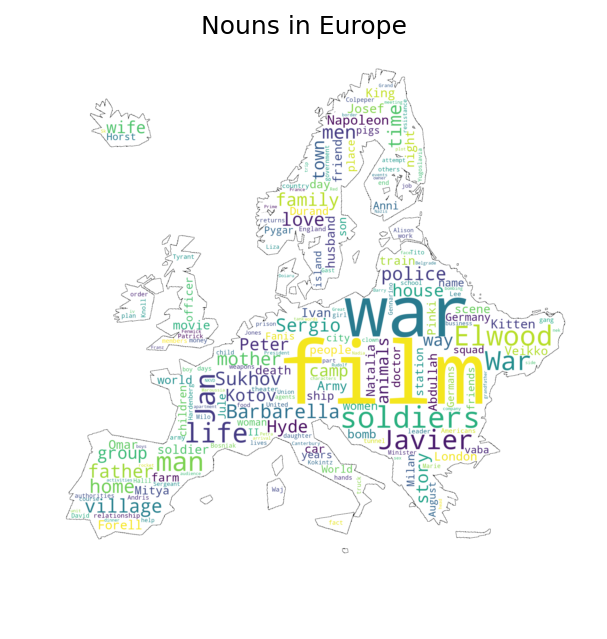

In [50]:
from src.utils.data_utils import generate_word_cloud_on_subset

generate_word_cloud_on_subset(
    region="Europe",
    pos_tags=noun_tags,
    title="Nouns in Europe",
    folder_path=folder_path,
    region_ids=region_ids,
    dataset_subsets=dataset_subsets,
    mask_image=europe_mask,
    sample_output=True,
    ngrams=1,
    subset_name="Biggest_Both",
    store_to=None,
    dpi=150
)

You can now create your desired word clouds! Simply adjust the parameters to generate any type of word cloud you can imagine.

## Applying Topic Modeling using SVD
We aim to uncover the underlying themes in movie plot summaries from the **America** and **Europe** datasets using **Singular Value Decomposition (SVD)**. This approach allows us to explore and compare thematic similarities and differences across regions.

We preprocessed the plot data by tokenizing, lemmatizing, and removing stopwords. These cleaned tokens are joined into complete strings and combined into a single corpus (**America**, **Europe**, and **Both**) to create a shared vocabulary using the `TfidfVectorizer`.

This shared vocabulary ensures consistent representation of words and phrases across all datasets. After fitting the vectorizer, we transform each region’s text into numerical representations (TF-IDF matrices). This allows us to analyze and compare themes and topics uniformly across regions.

In [51]:
# clean and prepare documents for America, Europe, and Both regions

documents_america = tokenized_plots_america.dropna().apply(lambda tokens: ' '.join(tokens))
documents_europe = tokenized_plots_europe.dropna().apply(lambda tokens: ' '.join(tokens))
documents_both = tokenized_plots_both.dropna().apply(lambda tokens: ' '.join(tokens))

# combine all documents into one dataset
all_documents = pd.concat([documents_america, documents_europe, documents_both])

In [52]:
custom_stopwords = {'film', 'movie', 'character', 'story', 'scene', 'plot', 'series'} # custom stopwords to filter out common plot terms

# initialize TF-IDF vectorizer with specific parameters
vectorizer = TfidfVectorizer(
    max_features=7000,
    stop_words='english',
    min_df=5,
    max_df=0.85,
    ngram_range=(1, 2),
    preprocessor=lambda text: " ".join([word for word in text.split() if word not in custom_stopwords])
)
vectorizer.fit(all_documents) # fit the vectorizer on the combined corpus

# transform each region’s documents into their TF-IDF matrices
tfidf_america = vectorizer.transform(documents_america)
tfidf_europe = vectorizer.transform(documents_europe)

We fit separate **Singular Value Decomposition (SVD)** models for each region using their respective TF-IDF matrices. Each model identifies 2 latent topics (`n_components=2`) within the text data for its region. 


In [53]:
# number of components 
components = 2

# initialize the TruncatedSVD models for both regions
svd_america = TruncatedSVD(n_components=components, algorithm='randomized', n_iter=100, random_state=42)
svd_europe = TruncatedSVD(n_components=components, algorithm='randomized', n_iter=100, random_state=42)

# fit SVD models to each region's TF-IDF matrix
svd_america.fit(tfidf_america)
svd_europe.fit(tfidf_europe)

# extract components (topics) for each region
components_america = svd_america.components_
components_europe = svd_europe.components_

# retrieve the vocabulary from the vectorizer
vocab = vectorizer.get_feature_names_out()

In [54]:
# import the function to display SVD topics
from src.utils.data_utils import get_svd_topics

# display topics for each region
print("America Topics:")
get_svd_topics(components_america, vocab)
print("\n------------------------\n")
print("Europe Topics:")
get_svd_topics(components_europe, vocab)

America Topics:
Topic 1: new | life | friend | man | love | family | father | girl | woman | school | tom | home
Topic 2: tom | jerry | cat | mouse | spike | tom jerry | tail | grab | dog | chase | tyke | hole

------------------------

Europe Topics:
Topic 1: life | man | young | woman | love | wife | family | friend | father | mother | girl | daughter
Topic 2: war | village | world war | world | soldier | british | war ii | ii | army | local | german | american


We use the `get_svd_topics` function to extract and display the top words for each topic generated by the SVD models.

This function works as follows:

1. **Iterates through each topic** in the SVD components.
2. **Selects the most important words** for each topic based on their corresponding weights.
3. **Maps the word indices** from the SVD components back to the original words using the `vocab`.
4. **Prints the top words** for each topic to help identify the key themes.

The `vocab` variable contains the list of terms extracted from the TF-IDF matrix. It allows the function to map the indices of the top words from the SVD components to their corresponding terms, helping to interpret the topics.

# <h1 style="text-align:center; color: #4164F0;">AXE 3 : Ethnic Representation 🤝🕊️</h1>

This part of the project aims to shed light on potential ethnic diversity in the American and European movie industy. Choosing this angle to look at the differences between the America and Europe will shed light on a serious topic, inculsion and equality, through the study of a comedic vehicule, Comedy.
We see very different proportions for ethic repartition of actors in European and American movies. <br>

### Loading and Preparing the Movie Actor Gender Data and Movie Actor Ethnicity Data

In [55]:
# file paths for the data
MOVIE_METADATA_PATH= '../MovieSummaries/movie.metadata.tsv'
CHARACTER_METADATA_PATH= '../MovieSummaries/character.metadata.tsv'
MERGED_MOVIE_METADATA_PATH='data/merged_movie_metadata.csv'

# load data
movie_metadata = pd.read_csv(MOVIE_METADATA_PATH, sep='\t', header=None, names=['Wikipedia_ID', 'Freebase_ID', 'Movie_Name', 'Release_Date', 'Box_Office_Revenue', 'Runtime', 'Languages', 'Countries', 'Genres'])

character_metadata = pd.read_csv(CHARACTER_METADATA_PATH, sep='\t', header=None, names=['Wikipedia_ID', 'Freebase_ID', 'Release_Date', 'Character_Name', 'Actor_Birth_Date', 'Actor_Gender', 'Actor_Height', 'Actor_Ethnicity', 'Actor_Name', 'Actor_Age', 'Character_Actor_Freebase_ID', 'Character_Freebase_ID', 'Actor_Freebase_ID'])

full_movie_metadata = pd.read_csv(MERGED_MOVIE_METADATA_PATH)

In [56]:
# print and display the shape and first 2 rows of the movie metadata
print("MOVIE METADATA:")
display(movie_metadata.shape, movie_metadata.head(2))

# print and display the shape and first 2 rows of the character metadata
print("CHARACTER METADATA:")
display(character_metadata.shape, character_metadata.head(2))

# print and display the shape and first 2 rows of the merged movie metadata
print("MERGED MOVIE METADATA:")
display(full_movie_metadata.shape, full_movie_metadata.head(2))

MOVIE METADATA:


(81741, 9)

Wikipedia_ID Freebase_ID  \
0        975900   /m/03vyhn   
1       3196793   /m/08yl5d   

                                          Movie_Name Release_Date  \
0                                     Ghosts of Mars   2001-08-24   
1  Getting Away with Murder: The JonBenét Ramsey ...   2000-02-16   

   Box_Office_Revenue  Runtime                           Languages  \
0          14010832.0     98.0  {"/m/02h40lc": "English Language"}   
1                 NaN     95.0  {"/m/02h40lc": "English Language"}   

                                   Countries  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   

                                              Genres  
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...  
1  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...

CHARACTER METADATA:


(450669, 13)

Wikipedia_ID Freebase_ID Release_Date              Character_Name  \
0        975900   /m/03vyhn   2001-08-24                    Akooshay   
1        975900   /m/03vyhn   2001-08-24  Lieutenant Melanie Ballard   

  Actor_Birth_Date Actor_Gender  Actor_Height Actor_Ethnicity  \
0       1958-08-26            F          1.62             NaN   
1       1974-08-15            F          1.78      /m/044038p   

           Actor_Name  Actor_Age Character_Actor_Freebase_ID  \
0      Wanda De Jesus       42.0                  /m/0bgchxw   
1  Natasha Henstridge       27.0                   /m/0jys3m   

  Character_Freebase_ID Actor_Freebase_ID  
0            /m/0bgcj3x        /m/03wcfv7  
1            /m/0bgchn4         /m/0346l4

MERGED MOVIE METADATA:


(13786, 33)

Wikipedia_ID                Movie_Name Release_Date  Box_Office_Revenue  \
0      13696889             The Gangsters   1913-05-29                 NaN   
1      10408933  Alexander's Ragtime Band   1938-08-16           3600000.0   

   Runtime                            Languages                     Countries  \
0     35.0  ['Silent film', 'English Language']  ['United States of America']   
1    106.0                 ['English Language']  ['United States of America']   

                                              Genres   Continents  Year  ...  \
0  ['Short Film', 'Silent film', 'Indie', 'Black-...  ['America']  1957  ...   
1           ['Musical', 'Comedy', 'Black-and-white']  ['America']  1938  ...   

  Production Website Response totalSeasons Oscar Nomination_Awards Win_Awards  \
0        NaN     NaN     True          NaN     0                 0          0   
1        NaN     NaN     True          NaN     1                 6          1   

  Internet_Movie_Database_Rating  Rotten_Tomatoes_Rating  Metacritic_Rating  
0                            5.9                     NaN                NaN  
1                            6.8                     8.3                NaN  

[2 rows x 33 columns]

### Visualising Data

#### 0. Functions

We import the following functions from the `data_utils` module to assist with plotting:

In [57]:
from src.utils.data_utils import plot_frequencie_proportion
from src.utils.data_utils import plot_frequencie
from src.utils.data_utils import plot_proportion
from src.utils.data_utils import plot_gender_distribution_regions

#### 1. Genders

In [58]:
# count the occurrences of each gender in the 'Actor_Gender' column, including NaN values
gender_count = character_metadata['Actor_Gender'].value_counts(dropna=False)

# display the top 4 gender counts with a styled table and a caption
display(
    gender_count.head(4).to_frame()
    .style.set_table_attributes('style="display:inline"') 
    .set_caption('<b>Actor Gender</b>')
)

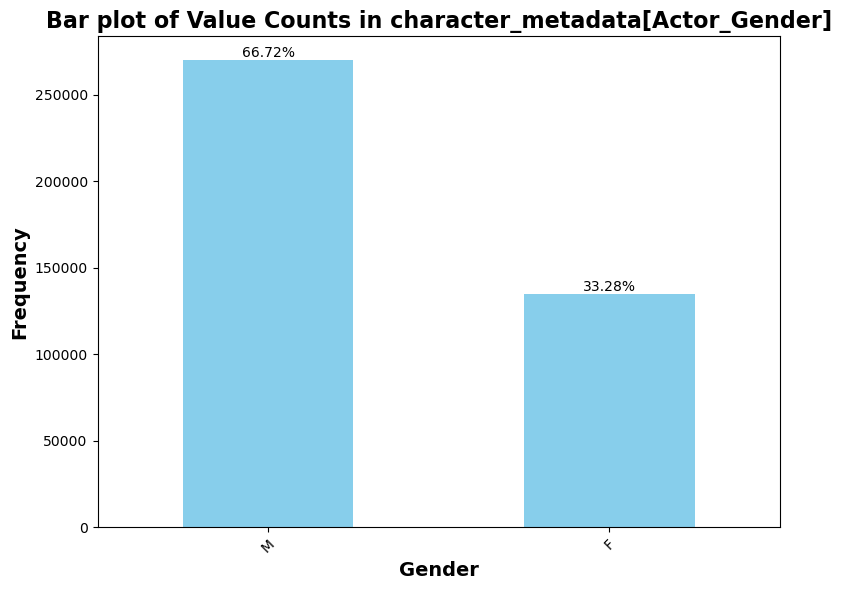

In [59]:
# Calculate gender counts
gender_count = character_metadata['Actor_Gender'].value_counts()

# Plot the gender distribution
plot_frequencie_proportion(
    data=gender_count,
    title="Bar plot of Value Counts in character_metadata[Actor_Gender]",
    xlabel="Gender"
)

##### Merging Data
Merge Actor_Gender and Actor_Freebase_ID on Wikipedia_ID of the movies_metadata in order to creat a DataFrame consisting of all movies associated with gendered actors

In [60]:
# merge full_movie_metadata with character_metadata on 'Wikipedia_ID'
full_movie_metadata_actor_gender = full_movie_metadata.merge(
    character_metadata[['Wikipedia_ID', 'Actor_Gender', 'Actor_Freebase_ID']],
    on='Wikipedia_ID',
    how='left'
)

In [61]:
# filter for American movies and count actor gender
full_movie_metadata_actor_gender_american = full_movie_metadata_actor_gender[full_movie_metadata_actor_gender['Continents'].apply(lambda x: 'America' in x)]
gender_count_a = full_movie_metadata_actor_gender_american['Actor_Gender'].value_counts(dropna=False)
display(gender_count_a.head(30).to_frame().style.set_table_attributes('style="display:inline"').set_caption('<b>Actor Gender (America)</b>'))

# filter for European movies and count actor gender
full_movie_metadata_actor_gender_europe = full_movie_metadata_actor_gender[full_movie_metadata_actor_gender['Continents'].apply(lambda x: 'Europe' in x)]
gender_count_e = full_movie_metadata_actor_gender_europe['Actor_Gender'].value_counts(dropna=False)
display(gender_count_e.head(30).to_frame().style.set_table_attributes('style="display:inline"').set_caption('<b>Actor Gender (Europe)</b>'))

# filter for both continents and count actor gender
full_movie_metadata_actor_gender_both = full_movie_metadata_actor_gender[full_movie_metadata_actor_gender['Continents'].apply(lambda x: 'Both' in x)]
gender_count_b = full_movie_metadata_actor_gender_both['Actor_Gender'].value_counts(dropna=False)
display(gender_count_b.head(30).to_frame().style.set_table_attributes('style="display:inline"').set_caption('<b>Actor Gender (Both)</b>'))

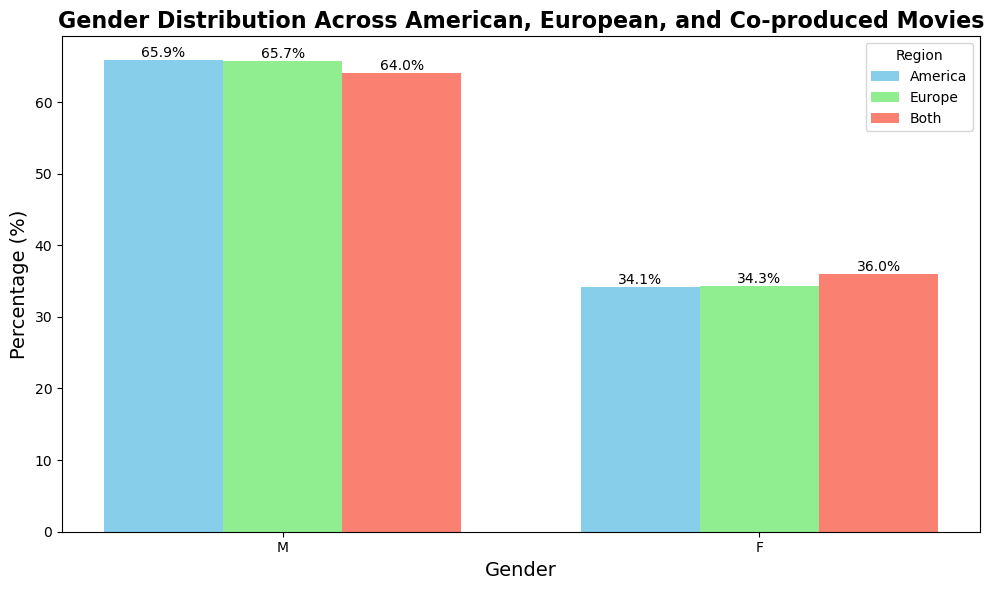

In [62]:
# plot gender distribution across American, European, and co-produced movies
plot_gender_distribution_regions(
    data=full_movie_metadata_actor_gender,
    title="Gender Distribution Across American, European, and Co-produced Movies"
)

We see very similar proportions for gender repartition in European and American movies. <br>
Further reaserch will focus on:
- The evolution of this proportion at different time periods in the two movie industries.
- The types of comedies where a significantly different proportion is observed on the two contients.
- Look for correlations in movie recognition (boxoffice/rankings/ratings/awards) and gender repatition.

#### 2. Ethnicity

In [63]:
# display the top 10 actor ethnicities
display(
    character_metadata['Actor_Ethnicity'].value_counts(dropna=False).head(10)
    .to_frame().style.set_table_attributes('style="display:inline"').set_caption('<b>Actor Ethnicities</b>')
)

#### This huge proportion of NaN is an issue, the first future step for this part would be to focus on treating these NaN. Since actors appear multiple times in character_metadata, Actor_Ethnicity might be taken from other occurence of this actor in the data.
For now we just drop the NaN values

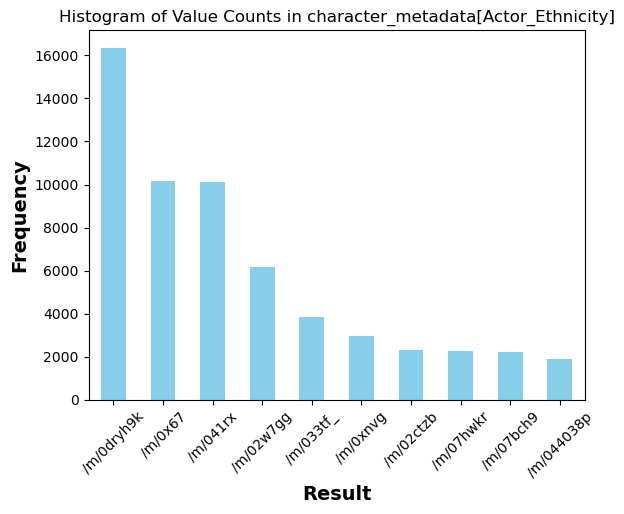

In [64]:
# get the top 10 most common ethnicities
ethnicity_count = character_metadata['Actor_Ethnicity'].value_counts().head(10)

# plot the histogram
ethnicity_count.plot(kind='bar', color='skyblue')
plt.title('Histogram of Value Counts in character_metadata[Actor_Ethnicity]')
plt.xlabel('Result', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Frequency', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xticks(rotation=45)
plt.show()

All ethnicities are named with a Freebase_ID, we need to map Ethnicities to corresponding Freebase_ID

Load and treating the mappings of Freebase_ID to Ethnicity

In [65]:
# load ethnicity mappings
ethnicity_map = pd.read_csv("data/ethnicity_mappings.csv")

# add a leading slash to Freebase_ID in ethnicity_map
ethnicity_map['freebase_id'] = ethnicity_map['freebase_id'].apply(lambda x: f'/{x}' if not x.startswith('/') else x)

# display the first 3 rows
ethnicity_map.head(3)

freebase_id                ethnicity
0     /m/0x67        African Americans
1   /m/064b9n  Omaha Tribe of Nebraska
2    /m/041rx            Jewish people

In [66]:
# convert the ethnicity_map DataFrame into a dictionary for mapping
ethnicity_dict = ethnicity_map.set_index('freebase_id')['ethnicity'].to_dict()

# map the Freebase IDs in character_metadata to their ethnicities
character_metadata['Actor_Ethnicity'] = character_metadata['Actor_Ethnicity'].map(ethnicity_dict)

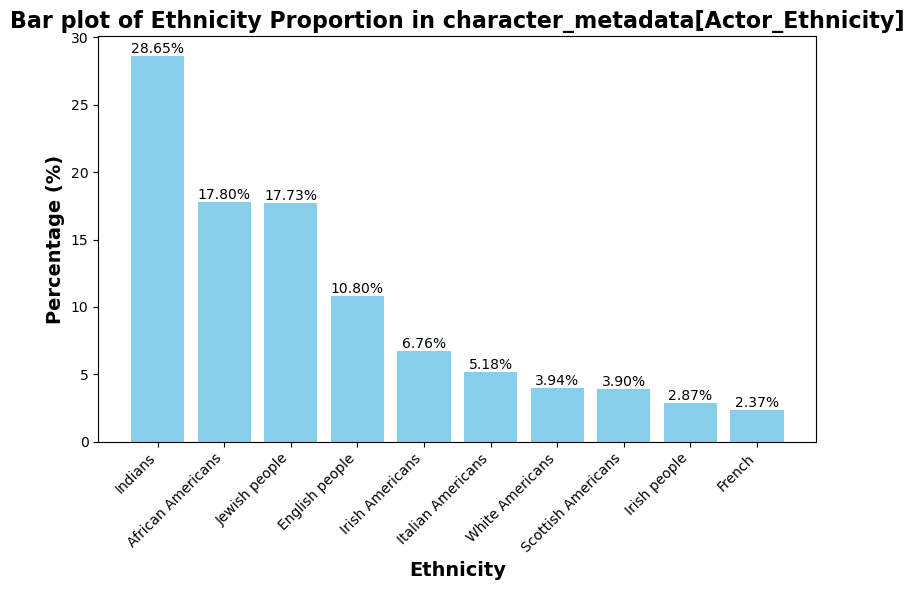

In [67]:
# get the top 10 most common ethnicities
ethnicity_count = character_metadata['Actor_Ethnicity'].value_counts().head(10)

# plot the ethnicity proportion
plot_proportion(ethnicity_count, "Bar plot of Ethnicity Proportion in character_metadata[Actor_Ethnicity]", "Ethnicity")

##### Merging Data
Merge Actor_Ethnicity and Actor_Freebase_ID on Wikipedia_ID of the movies_metadata in order to create a DataFrame consisting of all movies associated with informtaion about ethnicitiy of actors.

In [68]:
# merge full_movie_metadata with character_metadata on 'Wikipedia_ID' to add ethnicity information
full_movie_metadata_actor_ethnic = full_movie_metadata.merge(
    character_metadata[['Wikipedia_ID', 'Actor_Ethnicity', 'Actor_Freebase_ID']],
    on='Wikipedia_ID',
    how='left'
)

# display the first 3 rows
full_movie_metadata_actor_ethnic.head(3)

Wikipedia_ID                Movie_Name Release_Date  Box_Office_Revenue  \
0      13696889             The Gangsters   1913-05-29                 NaN   
1      10408933  Alexander's Ragtime Band   1938-08-16           3600000.0   
2      10408933  Alexander's Ragtime Band   1938-08-16           3600000.0   

   Runtime                            Languages                     Countries  \
0     35.0  ['Silent film', 'English Language']  ['United States of America']   
1    106.0                 ['English Language']  ['United States of America']   
2    106.0                 ['English Language']  ['United States of America']   

                                              Genres   Continents  Year  ...  \
0  ['Short Film', 'Silent film', 'Indie', 'Black-...  ['America']  1957  ...   
1           ['Musical', 'Comedy', 'Black-and-white']  ['America']  1938  ...   
2           ['Musical', 'Comedy', 'Black-and-white']  ['America']  1938  ...   

  Response totalSeasons Oscar Nomination_Awards Win_Awards  \
0     True          NaN     0                 0          0   
1     True          NaN     1                 6          1   
2     True          NaN     1                 6          1   

  Internet_Movie_Database_Rating Rotten_Tomatoes_Rating Metacritic_Rating  \
0                            5.9                    NaN               NaN   
1                            6.8                    8.3               NaN   
2                            6.8                    8.3               NaN   

      Actor_Ethnicity  Actor_Freebase_ID  
0  Scottish Americans           /m/0k57l  
1                 NaN           /m/0pkw7  
2    French Americans          /m/02s58t  

[3 rows x 35 columns]

In [69]:
# filter rows where 'Continents' is one of 'America', 'Europe', or 'Both'
full_movie_metadata_actor_ethnic_filtered = full_movie_metadata_actor_ethnic[
    full_movie_metadata_actor_ethnic['Continents'].apply(lambda x: 'America' in x or 'Europe' in x or 'Both' in x)
]

In [70]:
# filter for American movies and count actor ethnicity
full_movie_metadata_char_ethnic_american = full_movie_metadata_actor_ethnic[full_movie_metadata_actor_ethnic['Continents'].apply(lambda x: 'America' in x)]
ethnicity_count_a = full_movie_metadata_char_ethnic_american['Actor_Ethnicity'].value_counts()
display(ethnicity_count_a.head(5).to_frame().style.set_table_attributes('style="display:inline"').set_caption('<b>Actor Ethnicity (America)</b>'))

# filter for European movies and count actor ethnicity
full_movie_metadata_char_ethnic_europe = full_movie_metadata_actor_ethnic[full_movie_metadata_actor_ethnic['Continents'].apply(lambda x: 'Europe' in x)]
ethnicity_count_e = full_movie_metadata_char_ethnic_europe['Actor_Ethnicity'].value_counts()
display(ethnicity_count_e.head(5).to_frame().style.set_table_attributes('style="display:inline"').set_caption('<b>Actor Ethnicity (Europe)</b>'))

# filter for both continents and count actor ethnicity
full_movie_metadata_char_ethnic_both = full_movie_metadata_actor_ethnic[full_movie_metadata_actor_ethnic['Continents'].apply(lambda x: 'Both' in x)]
ethnicity_count_b = full_movie_metadata_char_ethnic_both['Actor_Ethnicity'].value_counts()
display(ethnicity_count_b.head(5).to_frame().style.set_table_attributes('style="display:inline"').set_caption('<b>Actor Ethnicity (Both)</b>'))


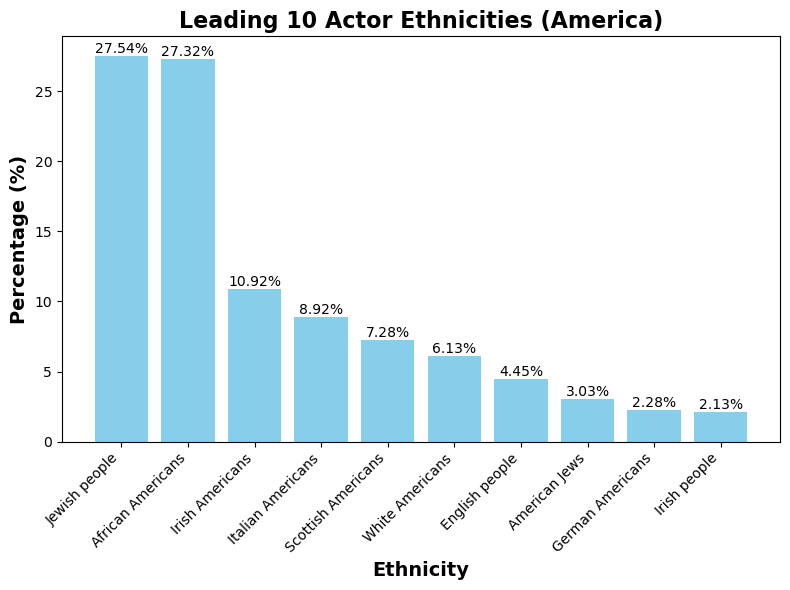

In [71]:
# plot the leading i actor ethnicities for America
plot_proportion(ethnicity_count_a.head(10), title=f'Leading {10} Actor Ethnicities (America)', xlabel="Ethnicity", color='skyblue')

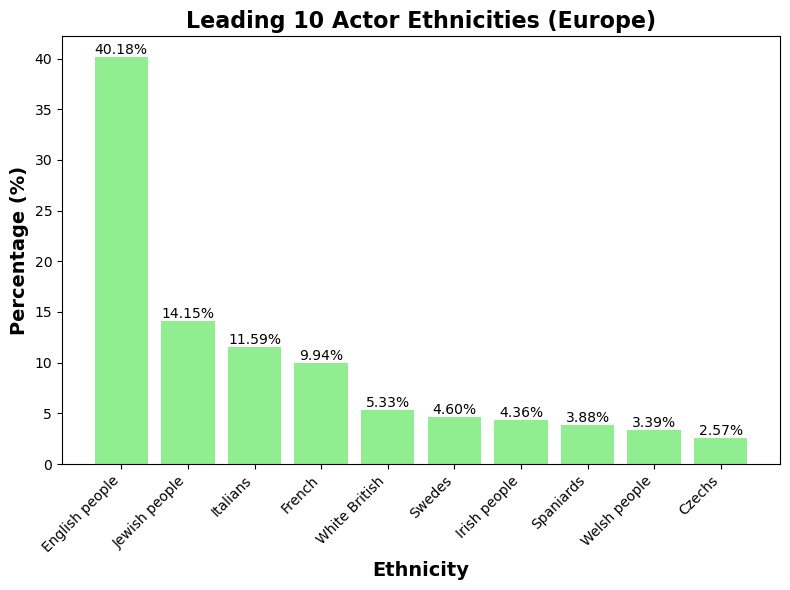

In [72]:
# plot the leading i actor ethnicities for Europe
plot_proportion(ethnicity_count_e.head(10), title=f'Leading {10} Actor Ethnicities (Europe)', xlabel="Ethnicity", color='lightgreen')

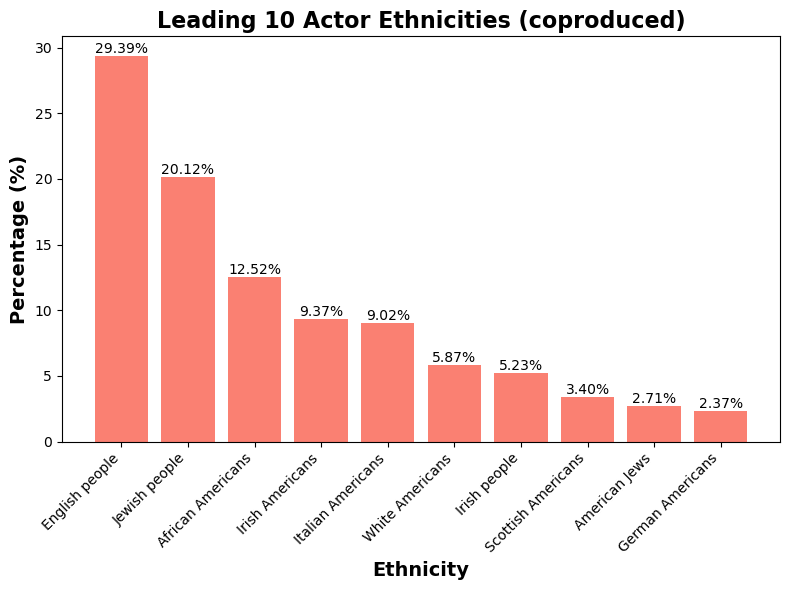

In [73]:
# plot the leading i actor ethnicities for coproduced movies
plot_proportion(ethnicity_count_b.head(10), title=f'Leading {10} Actor Ethnicities (coproduced)', xlabel="Ethnicity", color='salmon')

We see very different proportions for ethic repartition of actors in European and American movies. <br>
Future step invole creating broader ethnic cathegories to have simplified but more accurate representation of the movie industry ethnic landscape.
Further reaserch will focus on:
- The evolution of these varying proportions at different time periods in the two movie industries.
- The types of comedies where a significantly different proportion is observed on the two contients.
- Look for correlations in movie recognition (boxoffice/rankings/ratings/awards) and ethnical diversity in the cast.

## Exploring the Relationship Between Movie Appreciation and Cast Diversity

In [74]:
# import function to map ethnicity to hyperclass
from src.utils.data_utils import map_ethnicity_to_hyperclass

# map 'Actor_Ethnicity' to broader hyperclass categories and store in a new column
character_metadata['Actor_Large_Ethnicity'] = character_metadata['Actor_Ethnicity'].apply(
    lambda x: map_ethnicity_to_hyperclass(x)
)

In [75]:
# WARNING: this code takes around 1 hour to run on my pc. The result was saved as a csv and reloaded in the next cell

""" 
from src.utils.data_utils import casting, casting_ethnicity, diversity_score

# initialize an empty list to store diversity scores
scores = []
# loop through each film in the dataset
df = dataset_Genre_Cleaned
for film in df['Wikipedia_ID']:
    # retrieve the casting DataFrame for the film
    casting_df = casting(dataset_Genre_Cleaned, character_metadata, wikipedia_id=None)
    
    if casting_df is not None:
        # process ethnicity counts and compute diversity score
        counts = casting_ethnicity(casting_df)
        score = diversity_score(counts)
        scores.append(score)
    else:
        # handle cases where no casting data is available
        scores.append(0)
        print("No casting data available.")

# check the length of computed scores
print(f"Length: {len(scores)}")

# add the diversity scores to the dataset
df['Ethnicity_Score'] = scores

# save the updated dataset to a CSV file
df.to_csv('data/movie_metadata_scored2.csv')  
"""

' \nfrom src.utils.data_utils import casting, casting_ethnicity, diversity_score\n\n# initialize an empty list to store diversity scores\nscores = []\n# loop through each film in the dataset\ndf = dataset_Genre_Cleaned\nfor film in df[\'Wikipedia_ID\']:\n    # retrieve the casting DataFrame for the film\n    casting_df = casting(dataset_Genre_Cleaned, character_metadata, wikipedia_id=None)\n    \n    if casting_df is not None:\n        # process ethnicity counts and compute diversity score\n        counts = casting_ethnicity(casting_df)\n        score = diversity_score(counts)\n        scores.append(score)\n    else:\n        # handle cases where no casting data is available\n        scores.append(0)\n        print("No casting data available.")\n\n# check the length of computed scores\nprint(f"Length: {len(scores)}")\n\n# add the diversity scores to the dataset\ndf[\'Ethnicity_Score\'] = scores\n\n# save the updated dataset to a CSV file\ndf.to_csv(\'data/movie_metadata_scored2.csv\') 

In [76]:
# load the dataset with diversity scores
df = pd.read_csv('data/movie_metadata_scored.csv')

# filter the dataset for films associated with America, Europe, and Both
df_america = df[df['Continents'].apply(lambda x: 'America' in x)]
df_europe = df[df['Continents'].apply(lambda x: 'Europe' in x)]
df_both = df[df['Continents'].apply(lambda x: 'Both' in x)]

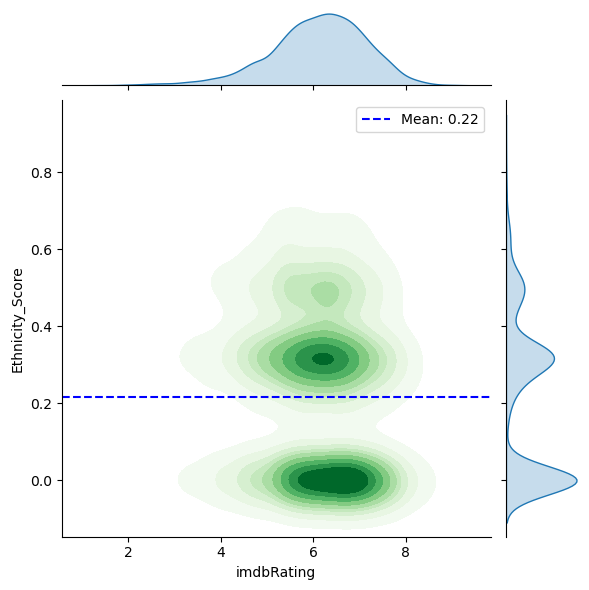

In [77]:
# filter the dataset to include only rows with non-null Ethnicity_Score
filtered_df = df.dropna(subset=['Ethnicity_Score'])

# calculate the mean of the Ethnicity_Score
mean_all = np.mean(filtered_df['Ethnicity_Score'])

# create a jointplot for the relationship between IMDb rating and Ethnicity Score
sns.jointplot(
    data=filtered_df, 
    x="imdbRating", 
    y="Ethnicity_Score", 
    kind="kde", 
    fill=True, 
    cmap="Greens"
)

# add a horizontal line representing the mean Ethnicity Score
plt.axhline(mean_all, color='blue', linestyle='--', label=f'Mean: {mean_all:.2f}')

# display
plt.legend()
plt.show()

In [78]:
# filter American films with non-null and non-zero Ethnicity_Score
filtered_df_america = df_america.dropna(subset=['Ethnicity_Score'])
filtered_df_america = filtered_df_america[filtered_df_america['Ethnicity_Score'] != 0.0]

# filter European films with non-null and non-zero Ethnicity_Score
filtered_df_europe = df_europe.dropna(subset=['Ethnicity_Score'])
filtered_df_europe = filtered_df_europe[filtered_df_europe['Ethnicity_Score'] != 0.0]

# filter films associated with both continents with non-null and non-zero Ethnicity_Score
filtered_df_both = df_both.dropna(subset=['Ethnicity_Score'])
filtered_df_both = filtered_df_both[filtered_df_both['Ethnicity_Score'] != 0.0]

# calculate the mean Ethnicity_Score for American films
mean_america = np.mean(filtered_df_america['Ethnicity_Score'])

# calculate the mean Ethnicity_Score for European films
mean_europe = np.mean(filtered_df_europe['Ethnicity_Score'])

<Figure size 1800x600 with 0 Axes>

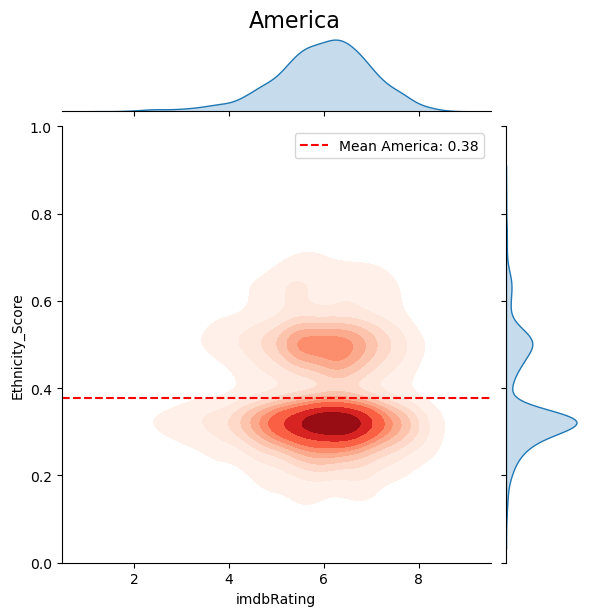

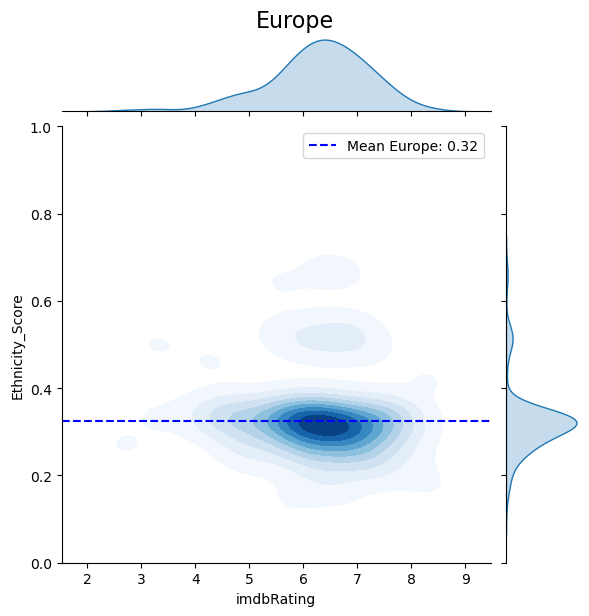

In [79]:
# set the figure size for better visualization
plt.figure(figsize=(18, 6))

# jointplot for American films
g1 = sns.jointplot(
    data=filtered_df_america, 
    x="imdbRating", 
    y="Ethnicity_Score", 
    kind="kde", 
    fill=True, 
    cmap="Reds"
)
g1.ax_joint.axhline(mean_america, color='red', linestyle='--', label=f'Mean America: {mean_america:.2f}')
g1.ax_joint.legend()
g1.ax_joint.set_ylim(0, 1)  # set the y-axis limit
g1.figure.suptitle('America', y=1.02, fontsize=16)

# jointplot for European films
g2 = sns.jointplot(
    data=filtered_df_europe, 
    x="imdbRating", 
    y="Ethnicity_Score", 
    kind="kde", 
    fill=True, 
    cmap="Blues"
)
g2.ax_joint.axhline(mean_europe, color='blue', linestyle='--', label=f'Mean Europe: {mean_europe:.2f}')
g2.ax_joint.legend()
g2.ax_joint.set_ylim(0, 1)  # set the y-axis limit
g2.figure.suptitle('Europe', y=1.02, fontsize=16)

# display
plt.show()

In [80]:
# extract ethnicity scores for American and European films
scores_america = filtered_df_america['Ethnicity_Score'].dropna()
scores_europe = filtered_df_europe['Ethnicity_Score'].dropna()

# perform a Student's t-test to compare the means
t_stat, p_value = ttest_ind(scores_america, scores_europe)

# print the t-statistic and p-value
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# define the significance level
alpha = 0.05

# check if the difference is statistically significant
if p_value < alpha:
    print("The difference in mean ethnicity scores is statistically significant.")
else:
    print("The difference in mean ethnicity scores is not statistically significant.")


T-statistic: 6.409524923954828
P-value: 1.7050567227166072e-10
The difference in mean ethnicity scores is statistically significant.


# Appendix
## Potential directions for future research

In [81]:
# create copies of each row for each genre in the original genres list
rows = []
for _, row in merged_movie_metadata.iterrows():
    for genre in row['comedy_genres']:
        new_row = row.copy()
        new_row['comedy_genres'] = genre
        rows.append(new_row)

# create a new DataFrame from the list of rows
exploded_df = pd.DataFrame(rows)

# display the first few rows to verify the changes
display(exploded_df.head())

# display the value counts of the 'comedy_genres' column
exploded_df["comedy_genres"].value_counts()

# display the shape of the exploded DataFrame
exploded_df.shape

Wikipedia_ID                Movie_Name Release_Date  Box_Office_Revenue  \
0      13696889             The Gangsters   1913-05-29                 NaN   
1      10408933  Alexander's Ragtime Band   1938-08-16           3600000.0   
2       9997961            Contigo y aquí         1974                 NaN   
2       9997961            Contigo y aquí         1974                 NaN   
3         77856              Mary Poppins   1964-08-27         102272727.0   

   Runtime                            Languages                     Countries  \
0     35.0  ['Silent film', 'English Language']  ['United States of America']   
1    106.0                 ['English Language']  ['United States of America']   
2     70.0                 ['Spanish Language']                 ['Argentina']   
2     70.0                 ['Spanish Language']                 ['Argentina']   
3    139.0                 ['English Language']  ['United States of America']   

                                              Genres Continents combi  Year  \
0  ['Short Film', 'Silent film', 'Indie', 'Black-...      ['America']  1957   
1           ['Musical', 'Comedy', 'Black-and-white']      ['America']  1938   
2                     ['Musical', 'Drama', 'Comedy']      ['America']  1974   
2                     ['Musical', 'Drama', 'Comedy']      ['America']  1974   
3  ["Children's/Family", 'Musical', 'Fantasy', 'C...      ['America']  1964   

   ... totalSeasons Oscar Nomination_Awards Win_Awards  \
0  ...          NaN     0                 0          0   
1  ...          NaN     1                 6          1   
2  ...          NaN     0                 0          0   
2  ...          NaN     0                 0          0   
3  ...          NaN     5                18         22   

  Internet_Movie_Database_Rating Rotten_Tomatoes_Rating Metacritic_Rating  \
0                            5.9                    NaN               NaN   
1                            6.8                    8.3               NaN   
2                            NaN                    NaN               NaN   
2                            NaN                    NaN               NaN   
3                            7.8                    9.7               8.8   

                                             Periods   comedy_genres  \
0             L'après-guerre et la comédie satirique           Other   
1  L'âge d'or du burlesque et de la screwball comedy  Comedy_Musical   
2                   Modernisation et diversification  Comedy_Musical   
2                   Modernisation et diversification    Comedy_Drama   
3             L'après-guerre et la comédie satirique  Comedy_Musical   

    Continents  
0  ['America']  
1  ['America']  
2  ['America']  
2  ['America']  
3  ['America']  

[5 rows x 36 columns]

(21905, 36)

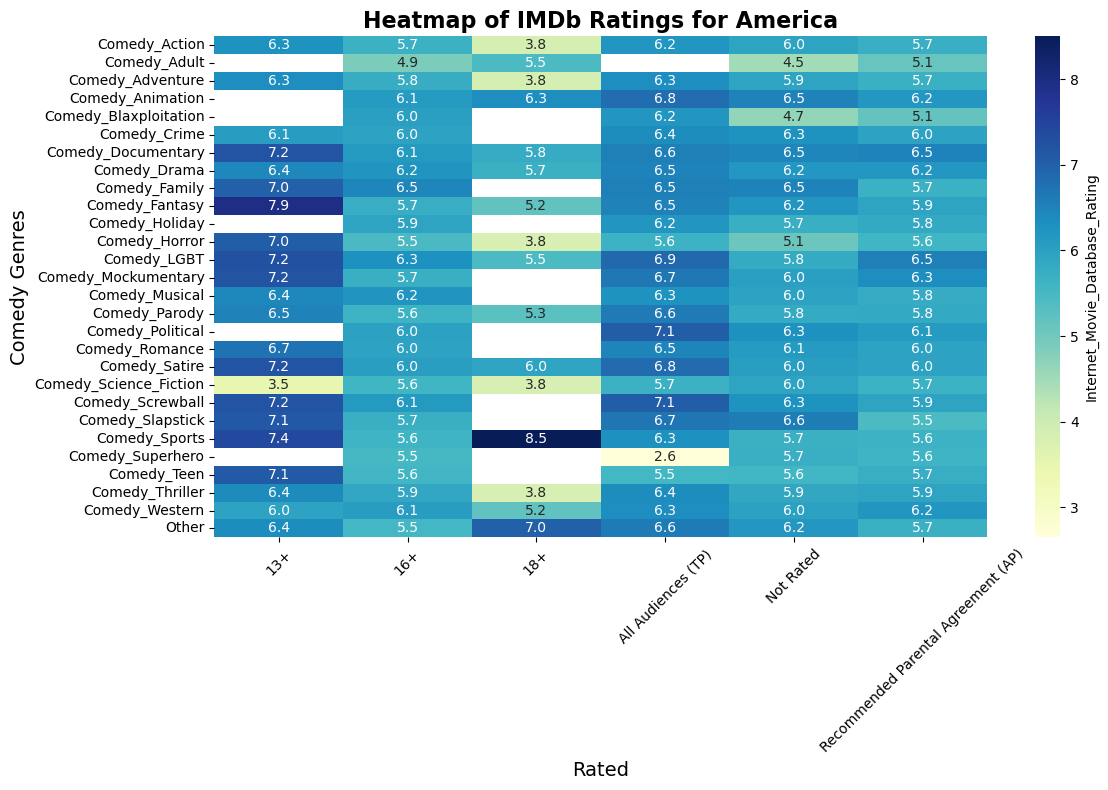

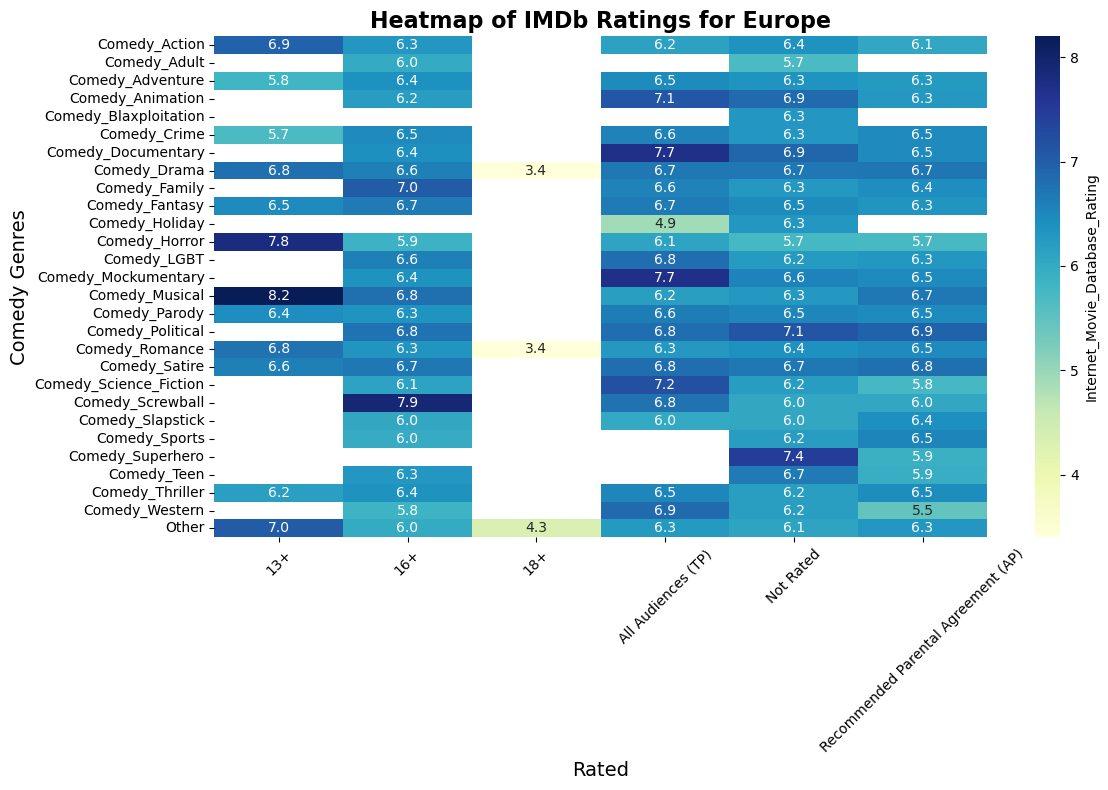

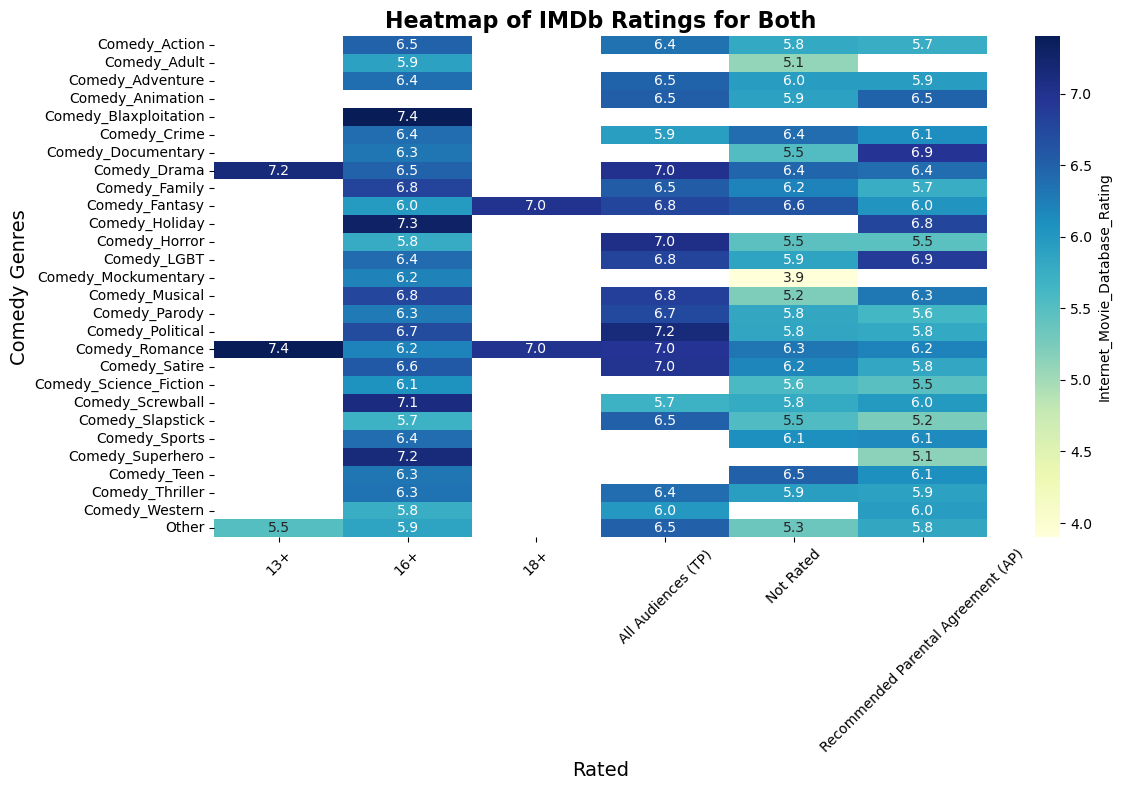

In [82]:
# import the create_heatmap function from the utils file
from src.utils.data_utils import create_heatmap

# create heatmaps for each continent
for continent in ['America', 'Europe', 'Both']:
    create_heatmap(continent, exploded_df)


In [83]:
# explode the 'Types' column to have one type per row
exploded_dataset = dataset_Genre_Cleaned.explode('Types')

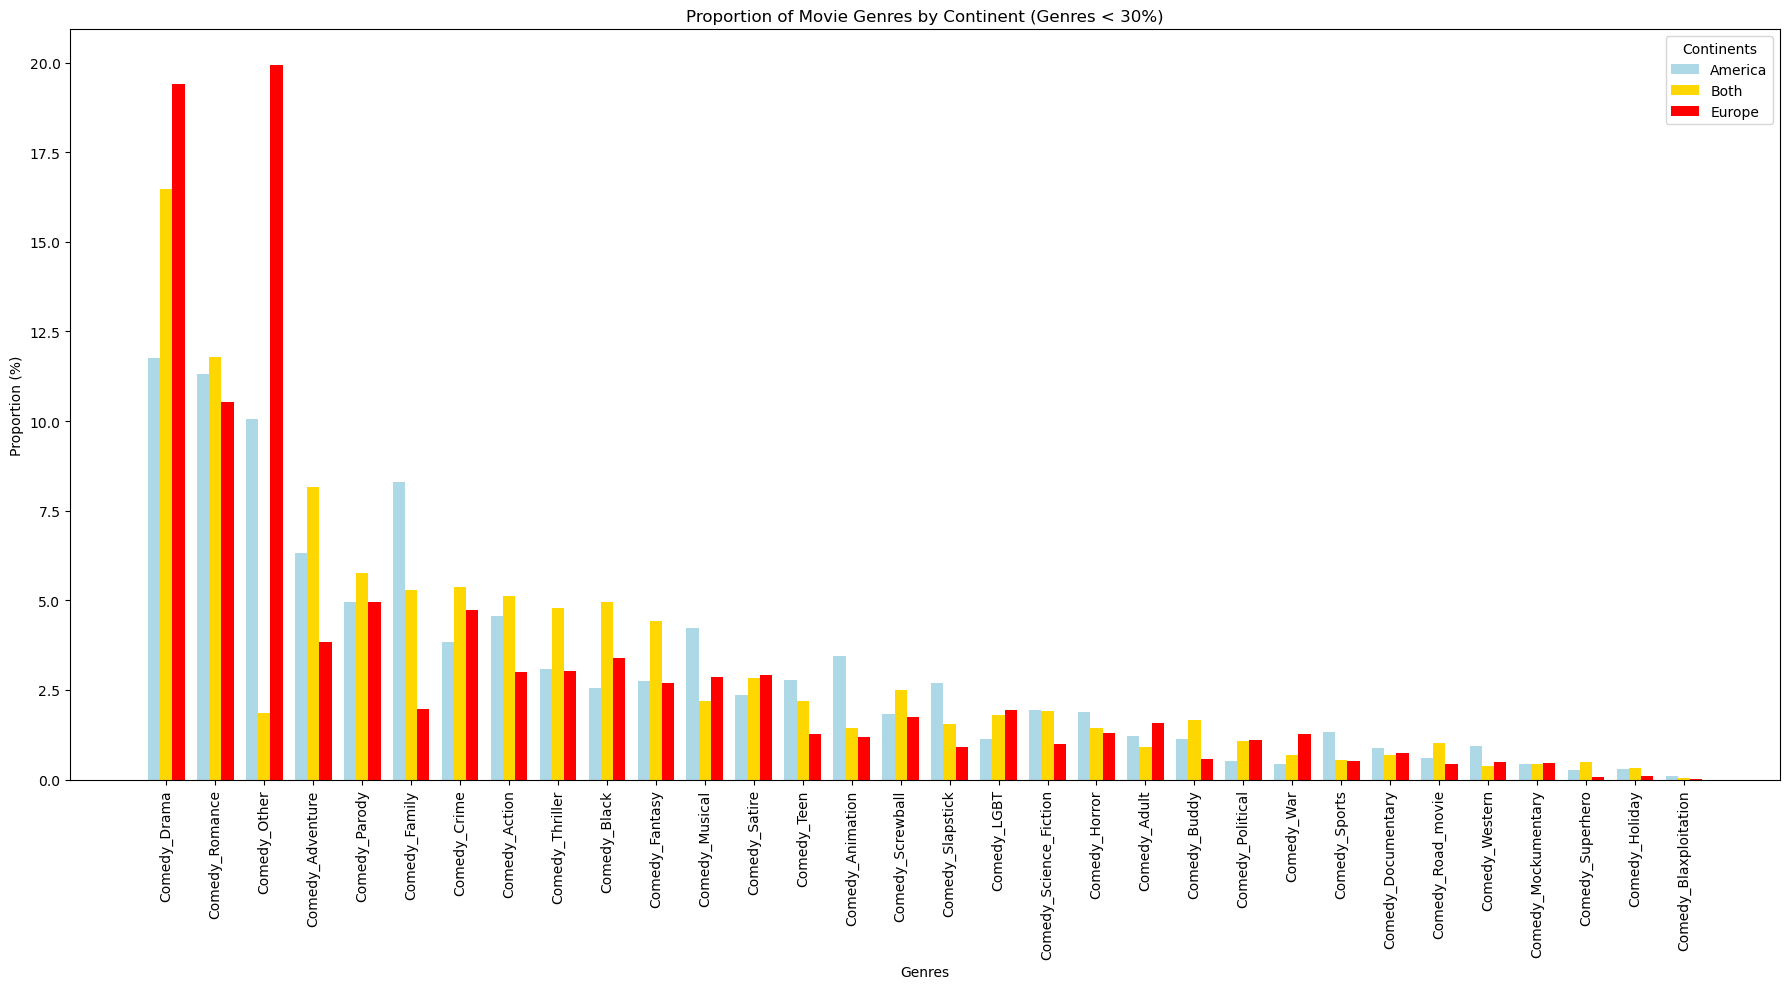

In [84]:
# calculate the proportion of each genre by continent
genre_proportion_by_continent = exploded_dataset.groupby(['Continents', 'Types']).size().unstack().apply(lambda x: x / x.sum(), axis=1) * 100

# filter to retain only genres where each continent has less than 10% proportion
threshold = 30
filtered_genre_proportion = genre_proportion_by_continent.loc[:, (genre_proportion_by_continent < threshold).all()]

# sort genres by total proportion in descending order
total_proportions = filtered_genre_proportion.sum(axis=0).sort_values(ascending=False)
filtered_genre_proportion = filtered_genre_proportion[total_proportions.index]

# initialize colors for each continent
colors = {
    'America': 'lightblue',
    'Both': 'gold',
    'Europe': 'red'
}

# define the gap between the bars
bar_width = 0.25
x = np.arange(len(filtered_genre_proportion.columns))  # positions for the filtered genres

# create a figure for side-by-side bars
plt.figure(figsize=(18, 10))

# plot bars for each continent
for i, (continent, color) in enumerate(colors.items()):
    if continent in filtered_genre_proportion.index:
        # offset for each continent
        plt.bar(x + i * bar_width, filtered_genre_proportion.loc[continent], width=bar_width, color=color, label=continent)

# set labels and title
plt.title('Proportion of Movie Genres by Continent (Genres < ' + str(threshold) + '%)')
plt.xlabel('Genres')
plt.ylabel('Proportion (%)')
plt.xticks(x + bar_width, filtered_genre_proportion.columns, rotation=90)
plt.legend(title='Continents', loc='upper right')

plt.tight_layout()
plt.show()

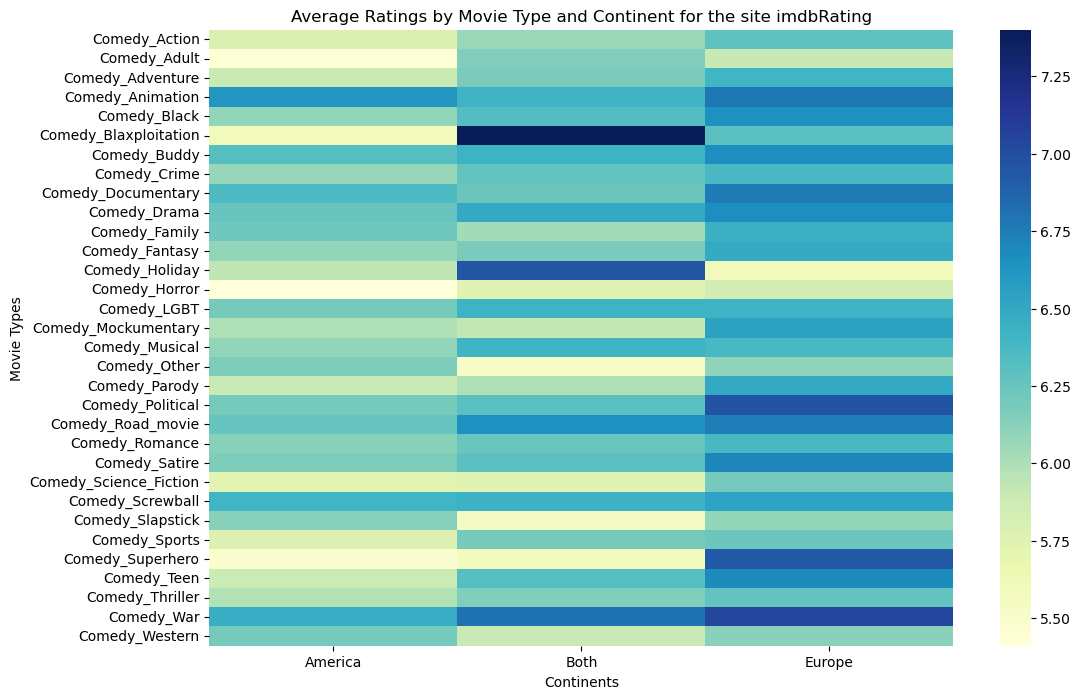

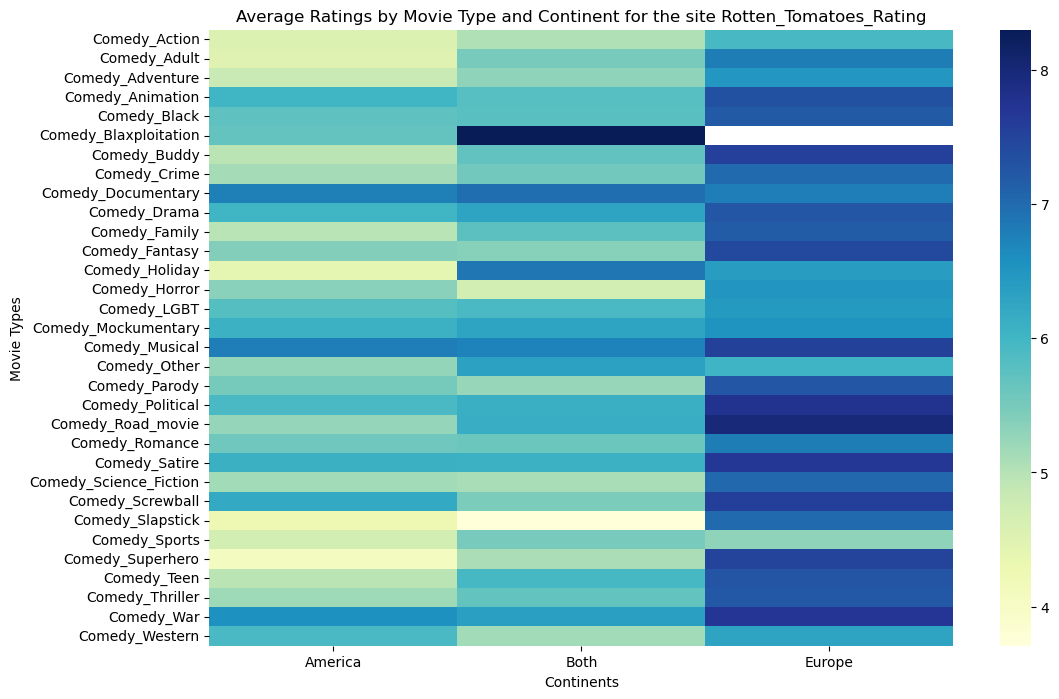

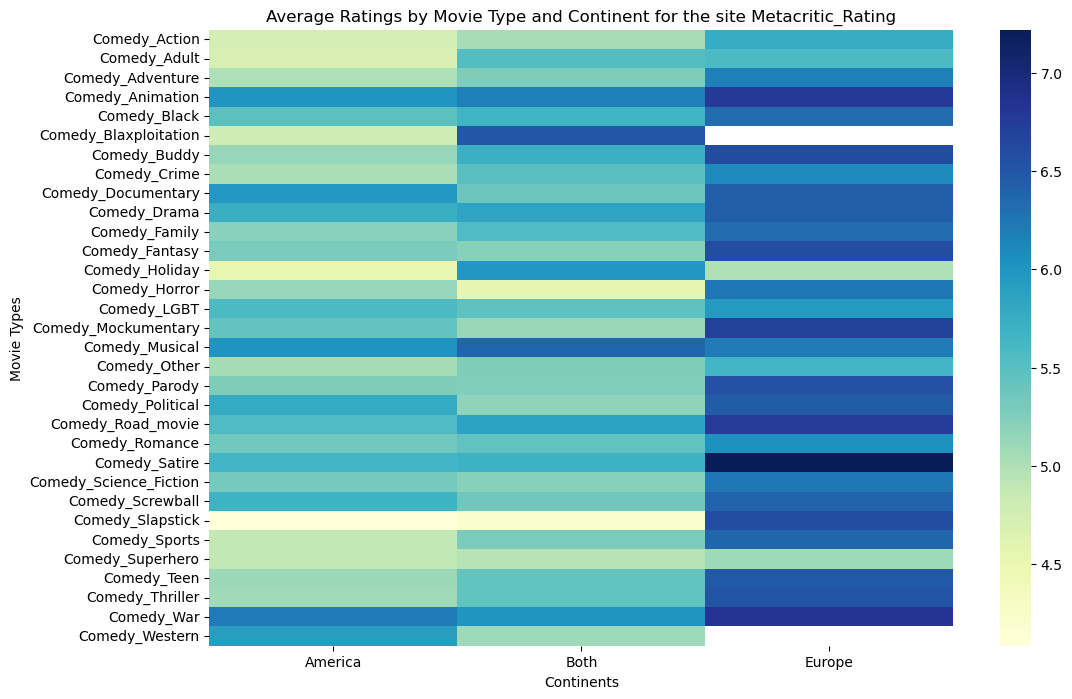

In [85]:
# iterate through the ratings columns
for rating in ratings_columns:

    # calculate the heatmap data based on 'Best_Rating'
    heatmap_data = exploded_dataset.groupby(['Types', 'Continents'])[rating].mean().unstack()

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        heatmap_data,
        cmap="YlGnBu",
    )
    plt.title(f"Average Ratings by Movie Type and Continent for the site {rating}")
    plt.xlabel("Continents")
    plt.ylabel("Movie Types")
    plt.show()